In [3]:
! pip install snowflake

## Import Packages

In [5]:
# Import Python packages
import pandas as pd
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import json
import sys
import cachetools
from datetime import timedelta
import math

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col, to_date

# For display purposes, suppress FutureWarnings and UserWarnings from printing below the cells
import warnings
for warning_category in [FutureWarning, UserWarning]:
    warnings.filterwarnings('ignore', category=warning_category)


## Connect to Snowflake

In [7]:
from snowflake.snowpark.context import get_active_session 
from getpass import getpass

connection_parameters = {
    'account' : "mapbobj-vp47779",
    'user' : 'soojin',
    "password": 'Kimbusan51480501@',

    
    'warehouse' : 'HACKATHON',
    'database' : 'RAW_DATA',
    'schema': 'GRANDATA'
}

# 세션 수동 생성
session = Session.builder.configs(connection_parameters).create()

# 쿼리 태그 설정 (추적용)
session.query_tag = {
    'origin': 'digital_nomad_project', # 프로젝트 명
    'name' : 'remote_work_trend_analysis', # 작업 목적
    'version' : {'major' : 1, 'minor' : 0},
    'attributes' : {
        'source' : 'jupyter',
        'analyst' : 'soojin kim '
    }
}

# print the current role, warehouse, and db/schema
print(f"role: {session.get_current_role()} | WH: {session.get_current_warehouse()} | DB.SCHEMA: {session.get_fully_qualified_current_schema()}")

role: "ACCOUNTADMIN" | WH: "HACKATHON" | DB.SCHEMA: "RAW_DATA"."GRANDATA"


In [14]:
from snowflake.snowpark import Session

connection_parameters = {
    "account": "mapbobj-vp47779",
    "user": "soojin",
    "password" : "Kimbusan51480501@",
    "warehouse": "HACKATHON",
    "database": "RAW_DATA",
    "schema": "GRANDATA",
    "authenticator": "snowflake"  # 브라우저 인증 방식
}

# 세션 재연결
session = Session.builder.configs(connection_parameters).create()

# 테이블 다시 불러오기
sales = session.table("CARD_SALES_INFO")
pop = session.table("FLOATING_POPULATION_INFO")


## 데이터 로딩 - Snowflake 테이블 연결

In [274]:
# 테이블 로딩 
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST") # GEO 정보는 Panda로 export 후 geopandas로 처리 가능

In [11]:
# 일단 데이터 확인 
# Snowpark DataFrame → Pandas DataFrame
card_df_pd = card_df.to_pandas()
float_df_pd = float_df.to_pandas()
asset_df_pd = asset_df.to_pandas()
admin_df_pd = admin_df.to_pandas()

## 데이터 확인해보기 - 시각화로

In [13]:
# 예시: 상위 5개 행 확인
print(card_df_pd.head())

  PROVINCE_CODE CITY_CODE DISTRICT_CODE STANDARD_YEAR_MONTH CARD_TYPE  \
0            11     11140      11140126              202205         1   
1            11     11140      11140126              202205         1   
2            11     11140      11140126              202205         1   
3            11     11140      11140126              202205         1   
4            11     11140      11140126              202205         1   

  WEEKDAY_WEEKEND GENDER AGE_GROUP TIME_SLOT LIFESTYLE  ...  TRAVEL_COUNT  \
0               W      M        35       T24       L03  ...           0.0   
1               W      F        50       T21       L05  ...           0.0   
2               W      M        35       T24       L01  ...           0.0   
3               W      M        30       T18         *  ...           0.0   
4               H      F        40       T12       L03  ...           0.0   

   BEAUTY_COUNT  HOME_LIFE_SERVICE_COUNT  EDUCATION_ACADEMY_COUNT  \
0           0.0              

In [14]:
# 스키마(컬럼명, 데이터타입) 출력
print("📌 CARD_SALES_INFO schema:")
card_df.print_schema()
print("Total rows:", card_df.count())

print("\n📌 FLOATING_POPULATION_INFO schema:")
float_df.print_schema()
print("Total rows:", float_df.count())

print("\n📌 ASSET_INCOME_INFO schema:")
asset_df.print_schema()
print("Total rows:", asset_df.count())

print("\n📌 M_SCCO_MST schema:")
admin_df.print_schema()
print("Total rows:", admin_df.count())


📌 CARD_SALES_INFO schema:
root
 |-- "PROVINCE_CODE": StringType(2) (nullable = False)
 |-- "CITY_CODE": StringType(5) (nullable = False)
 |-- "DISTRICT_CODE": StringType(8) (nullable = False)
 |-- "STANDARD_YEAR_MONTH": StringType(6) (nullable = False)
 |-- "CARD_TYPE": StringType(1) (nullable = False)
 |-- "WEEKDAY_WEEKEND": StringType(1) (nullable = False)
 |-- "GENDER": StringType(1) (nullable = False)
 |-- "AGE_GROUP": StringType(2) (nullable = False)
 |-- "TIME_SLOT": StringType(3) (nullable = False)
 |-- "LIFESTYLE": StringType(3) (nullable = False)
 |-- "TOTAL_SALES": LongType() (nullable = True)
 |-- "FOOD_SALES": LongType() (nullable = True)
 |-- "COFFEE_SALES": LongType() (nullable = True)
 |-- "ENTERTAINMENT_SALES": LongType() (nullable = True)
 |-- "DEPARTMENT_STORE_SALES": LongType() (nullable = True)
 |-- "LARGE_DISCOUNT_STORE_SALES": LongType() (nullable = True)
 |-- "SMALL_RETAIL_STORE_SALES": LongType() (nullable = True)
 |-- "CLOTHING_ACCESSORIES_SALES": LongType() (n

In [18]:
# 일부 데이터 가져오기
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# 출력
print("\n💳 CARD_SALES_INFO sample:")
print(card_sample)

print("\n👥 FLOATING_POPULATION_INFO sample:")
print(float_sample)

print("\n💰 ASSET_INCOME_INFO sample:")
print(asset_sample)

print("\n🗺️ M_SCCO_MST sample:")
print(admin_sample)



💳 CARD_SALES_INFO sample:
  PROVINCE_CODE CITY_CODE DISTRICT_CODE STANDARD_YEAR_MONTH CARD_TYPE  \
0            11     11140      11140129              202112         1   
1            11     11140      11140129              202112         1   
2            11     11140      11140129              202112         1   
3            11     11140      11140129              202112         1   
4            11     11140      11140129              202112         1   

  WEEKDAY_WEEKEND GENDER AGE_GROUP TIME_SLOT LIFESTYLE  ...  TRAVEL_COUNT  \
0               H      M        30       T15       L01  ...           0.0   
1               W      F        55       T21       L01  ...           0.0   
2               W      M        40       T12       L02  ...           0.0   
3               W      M        60       T15       L04  ...           0.0   
4               W      F        50       T12       L01  ...           0.0   

   BEAUTY_COUNT  HOME_LIFE_SERVICE_COUNT  EDUCATION_ACADEMY_COUNT  \
0 

In [20]:
# Snowpark 테이블 불러오기
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST")

# 일부 행만 Pandas DataFrame으로 변환
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# 데이터 확인
import pandas as pd
from IPython.display import display

print("💳 CARD_SALES_INFO Sample")
display(card_sample)

print("👥 FLOATING_POPULATION_INFO Sample")
display(float_sample)

print("💰 ASSET_INCOME_INFO Sample")
display(asset_sample)

print("🗺️ M_SCCO_MST Sample")
display(admin_sample)


💳 CARD_SALES_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,...,TRAVEL_COUNT,BEAUTY_COUNT,HOME_LIFE_SERVICE_COUNT,EDUCATION_ACADEMY_COUNT,MEDICAL_COUNT,ELECTRONICS_FURNITURE_COUNT,CAR_SALES_COUNT,CAR_SERVICE_SUPPLIES_COUNT,GAS_STATION_COUNT,E_COMMERCE_COUNT
0,11,11140,11140129,202112,1,H,M,30,T15,L01,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,11140,11140129,202112,1,W,F,55,T21,L01,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,11140,11140129,202112,1,W,M,40,T12,L02,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,11140,11140129,202112,1,W,M,60,T15,L04,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,11140,11140129,202112,1,W,F,50,T12,L01,...,0.0,5.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


👥 FLOATING_POPULATION_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,11140,11140101,202101,W,M,40,T12,5.27,204.62,120.09
1,11,11140,11140101,202101,H,F,20,T18,0.30,6.46,14.26
2,11,11140,11140101,202101,H,M,40,T12,4.56,15.22,30.69
3,11,11140,11140101,202101,H,M,20,T21,0.48,1.38,4.83
4,11,11140,11140101,202101,H,M,65,T15,1.38,3.04,9.30


💰 ASSET_INCOME_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,INCOME_TYPE,GENDER,AGE_GROUP,CUSTOMER_COUNT,RATE_MODEL_GROUP_LARGE_COMPANY_EMPLOYEE,RATE_MODEL_GROUP_GENERAL_EMPLOYEE,...,AVERAGE_SCORE,RATE_SCORE1,RATE_SCORE2,RATE_SCORE3,AVERAGE_LOAN_POTENTIAL1,AVERAGE_LOAN_POTENTIAL2,OWN_HOUSING_COUNT,MULTIPLE_HOUSING_COUNT,AVERAGE_ASSET_AMOUNT,RATE_HIGHEND
0,11,11560,11560101,202108,0,F,45,501,0.91,47.00,...,3,77.26,16.70,6.13,222635,-30344,88,27,377309,5.91
1,11,11560,11560101,202108,1,M,40,592,5.84,43.66,...,3,57.56,33.73,6.86,1648186,763775,140,29,407892,13.82
2,11,11560,11560101,202108,1,M,50,804,3.51,35.81,...,4,47.93,40.04,10.31,2599543,1599275,185,50,385991,16.01
3,11,11560,11560101,202108,1,F,35,631,3.07,50.84,...,3,62.86,33.60,2.24,1229941,526744,90,19,354258,5.97
4,11,11560,11560101,202108,1,M,20,448,0.35,14.67,...,5,12.13,84.88,3.06,571829,-222711,4,2,379852,0.92


🗺️ M_SCCO_MST Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,PROVINCE_KOR_NAME,CITY_KOR_NAME,DISTRICT_KOR_NAME,PROVINCE_ENG_NAME,CITY_ENG_NAME,DISTRICT_ENG_NAME,DISTRICT_GEOM
0,11,11110,11110101,서울특별시,종로구,청운동,Seoul,Jongno-gu,Cheongun-dong,"{\n ""coordinates"": [\n [\n [\n ..."
1,11,11110,11110102,서울특별시,종로구,신교동,Seoul,Jongno-gu,Singyo-dong,"{\n ""coordinates"": [\n [\n [\n ..."
2,11,11110,11110103,서울특별시,종로구,궁정동,Seoul,Jongno-gu,Gungjeong-dong,"{\n ""coordinates"": [\n [\n [\n ..."
3,11,11110,11110104,서울특별시,종로구,효자동,Seoul,Jongno-gu,Hyoja-dong,"{\n ""coordinates"": [\n [\n [\n ..."
4,11,11110,11110105,서울특별시,종로구,창성동,Seoul,Jongno-gu,Changseong-dong,"{\n ""coordinates"": [\n [\n [\n ..."


In [175]:
# Pandas 옵션 추가 (최상단에 넣어도 좋음)
import pandas as pd
from IPython.display import display

# 👇 이거 추가하면 전체 column, row 다 보임
pd.set_option('display.max_columns', None)  # 컬럼 전체 보기
pd.set_option('display.max_rows', 100)      # 필요 시 100개 정도까지 행 보기
pd.set_option('display.width', None)        # 가로 스크롤 없이 너비 다 보기
pd.set_option('display.max_colwidth', None) # 셀 안 내용 생략 없이 보기

# --- Snowflake 테이블 불러오기 ---
card_df = session.table("CARD_SALES_INFO")
float_df = session.table("FLOATING_POPULATION_INFO")
asset_df = session.table("ASSET_INCOME_INFO")
admin_df = session.table("M_SCCO_MST")

# --- 일부 행만 Pandas DataFrame으로 변환 ---
card_sample = card_df.limit(5).to_pandas()
float_sample = float_df.limit(5).to_pandas()
asset_sample = asset_df.limit(5).to_pandas()
admin_sample = admin_df.limit(5).to_pandas()

# --- 데이터 출력 ---
print("💳 CARD_SALES_INFO Sample")
display(card_sample)

print("👥 FLOATING_POPULATION_INFO Sample")
display(float_sample)

print("💰 ASSET_INCOME_INFO Sample")
display(asset_sample)

print("🗺️ M_SCCO_MST Sample")
# display(admin_sample)


💳 CARD_SALES_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,FOOD_SALES,COFFEE_SALES,ENTERTAINMENT_SALES,DEPARTMENT_STORE_SALES,LARGE_DISCOUNT_STORE_SALES,SMALL_RETAIL_STORE_SALES,CLOTHING_ACCESSORIES_SALES,SPORTS_CULTURE_LEISURE_SALES,ACCOMMODATION_SALES,TRAVEL_SALES,BEAUTY_SALES,HOME_LIFE_SERVICE_SALES,EDUCATION_ACADEMY_SALES,MEDICAL_SALES,ELECTRONICS_FURNITURE_SALES,CAR_SALES,CAR_SERVICE_SUPPLIES_SALES,GAS_STATION_SALES,E_COMMERCE_SALES,TOTAL_COUNT,FOOD_COUNT,COFFEE_COUNT,ENTERTAINMENT_COUNT,DEPARTMENT_STORE_COUNT,LARGE_DISCOUNT_STORE_COUNT,SMALL_RETAIL_STORE_COUNT,CLOTHING_ACCESSORIES_COUNT,SPORTS_CULTURE_LEISURE_COUNT,ACCOMMODATION_COUNT,TRAVEL_COUNT,BEAUTY_COUNT,HOME_LIFE_SERVICE_COUNT,EDUCATION_ACADEMY_COUNT,MEDICAL_COUNT,ELECTRONICS_FURNITURE_COUNT,CAR_SALES_COUNT,CAR_SERVICE_SUPPLIES_COUNT,GAS_STATION_COUNT,E_COMMERCE_COUNT
0,11,11140,11140129,202112,1,H,M,30,T15,L01,7956954,3027922,862684,0,0,0,615612,0,3450736,0,0,0,0,0,0,0,0,0,0,0,258.46,129.23,51.69,0.0,0.0,0.0,51.69,0.00,25.85,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,11140,11140129,202112,1,W,F,55,T21,L01,157650,157650,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.34,10.34,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,11140,11140129,202112,1,W,M,40,T12,L02,3639917,865269,128705,0,0,0,1049280,0,1596663,0,0,0,0,0,0,0,0,0,0,0,206.76,46.53,10.34,0.0,0.0,0.0,129.22,0.00,20.68,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11,11140,11140129,202112,1,W,M,60,T15,L04,284287,85286,173157,0,0,0,0,0,0,25844,0,0,0,0,0,0,0,0,0,0,36.19,10.34,20.68,0.0,0.0,0.0,0.00,0.00,0.00,5.17,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,11140,11140129,202112,1,W,F,50,T12,L01,483289,356651,0,0,0,0,0,56858,0,0,0,69780,0,0,0,0,0,0,0,0,46.53,36.19,0.00,0.0,0.0,0.0,0.00,5.17,0.00,0.00,0.0,5.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


👥 FLOATING_POPULATION_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,11140,11140101,202101,W,M,40,T12,5.27,204.62,120.09
1,11,11140,11140101,202101,H,F,20,T18,0.30,6.46,14.26
2,11,11140,11140101,202101,H,M,40,T12,4.56,15.22,30.69
3,11,11140,11140101,202101,H,M,20,T21,0.48,1.38,4.83
4,11,11140,11140101,202101,H,M,65,T15,1.38,3.04,9.30


💰 ASSET_INCOME_INFO Sample


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,INCOME_TYPE,GENDER,AGE_GROUP,CUSTOMER_COUNT,RATE_MODEL_GROUP_LARGE_COMPANY_EMPLOYEE,RATE_MODEL_GROUP_GENERAL_EMPLOYEE,RATE_MODEL_GROUP_PROFESSIONAL_EMPLOYEE,RATE_MODEL_GROUP_EXECUTIVES,RATE_MODEL_GROUP_GENERAL_SELF_EMPLOYED,RATE_MODEL_GROUP_PROFESSIONAL_SELF_EMPLOYED,RATE_MODEL_GROUP_OTHERS,PYEONG_UNDER_20_COUNT,PYEONG_OVER_20_COUNT,PYEONG_OVER_30_COUNT,PYEONG_OVER_40_COUNT,AVERAGE_PRICE_GAP,AVERAGE_LEASE_GAP,AVERAGE_INCOME,AVERAGE_INCOME_OVER_70,AVERAGE_HOUSEHOLD_INCOME,MEDIAN_INCOME,RATE_INCOME_UNDER_20M,RATE_INCOME_20M_TO_30M,RATE_INCOME_30M_TO_40M,RATE_INCOME_40M_TO_50M,RATE_INCOME_50M_TO_60M,RATE_INCOME_60M_TO_70M,RATE_INCOME_OVER_70M,CARD_COUNT,CREDIT_CARD_COUNT,CHECK_CARD_COUNT,AVERAGE_CARD_COUNT,AVERAGE_CREDIT_CARD_COUNT,AVERAGE_CHECK_CARD_COUNT,TOTAL_USAGE_AMOUNT,TOTAL_SALES_USAGE_AMOUNT,TOTAL_FULL_PAYMENT_USAGE_AMOUNT,TOTAL_INSTALLMENT_USAGE_AMOUNT,TOTAL_CASH_ADVANCE_USAGE_AMOUNT,TOTAL_CREDIT_CARD_USAGE_AMOUNT,TOTAL_CHECK_CARD_USAGE_AMOUNT,TOTAL_ABROAD_AMOUNT,AVERAGE_USAGE_AMOUNT,AVERAGE_SALES_USAGE_AMOUNT,AVERAGE_FULL_PAYMENT_USAGE_AMOUNT,AVERAGE_INSTALLMENT_USAGE_AMOUNT,AVERAGE_CASH_ADVANCE_USAGE_AMOUNT,AVERAGE_CREDIT_CARD_USAGE_AMOUNT,AVERAGE_CHECK_CARD_USAGE_AMOUNT,AVERAGE_ABROAD_AMOUNT,AVERAGE_TOTAL_LIMIT_AMOUNT,BALANCE_COUNT,BANK_BALANCE_COUNT,NON_BANK_BALANCE_COUNT,CREDIT_BALANCE_COUNT,HOUSING_BALANCE_COUNT,MORTGAGE1_BALANCE_COUNT,MORTGAGE2_BALANCE_COUNT,AVERAGE_BALANCE_COUNT,AVERAGE_BANK_BALANCE_COUNT,AVERAGE_NON_BANK_BALANCE_COUNT,AVERAGE_CREDIT_BALANCE_COUNT,AVERAGE_HOUSING_BALANCE_COUNT,AVERAGE_MORTGAGE1_BALANCE_COUNT,AVERAGE_MORTGAGE2_BALANCE_COUNT,TOTAL_BALANCE_AMOUNT,TOTAL_BANK_BALANCE_AMOUNT,TOTAL_NON_BANK_BALANCE_AMOUNT,TOTAL_CREDIT_BALANCE_AMOUNT,TOTAL_HOUSING_BALANCE_AMOUNT,TOTAL_MORTGAGE1_BALANCE_AMOUNT,TOTAL_MORTGAGE2_BALANCE_AMOUNT,AVERAGE_BALANCE_AMOUNT,AVERAGE_BANK_BALANCE_AMOUNT,AVERAGE_NON_BANK_BALANCE_AMOUNT,AVERAGE_CREDIT_BALANCE_AMOUNT,AVERAGE_HOUSING_BALANCE_AMOUNT,AVERAGE_MORTGAGE1_BALANCE_AMOUNT,AVERAGE_MORTGAGE2_BALANCE_AMOUNT,NEW_BALANCE_COUNT,NEW_BANK_BALANCE_COUNT,NEW_NON_BANK_BALANCE_COUNT,NEW_CREDIT_BALANCE_COUNT,NEW_HOUSING_BALANCE_COUNT,NEW_MORTGAGE1_BALANCE_COUNT,NEW_MORTGAGE2_BALANCE_COUNT,NEW_TOTAL_BALANCE_AMOUNT,NEW_TOTAL_BANK_BALANCE_AMOUNT,NEW_TOTAL_NON_BANK_BALANCE_AMOUNT,NEW_TOTAL_CREDIT_BALANCE_AMOUNT,NEW_TOTAL_HOUSING_BALANCE_AMOUNT,NEW_TOTAL_MORTGAGE1_BALANCE_AMOUNT,NEW_TOTAL_MORTGAGE2_BALANCE_AMOUNT,DELINQUENT0_COUNT,DELINQUENT30_COUNT,DELINQUENT90_COUNT,AVERAGE_DELINQUENT_COUNT,AVERAGE_DELINQUENT_DAYS,AVERAGE_MAX_DELINQUENT_DAYS,AVERAGE_DELINQUENT_AMOUNT,MEDIAN_DELINQUENT_AMOUNT,AVERAGE_SCORE,RATE_SCORE1,RATE_SCORE2,RATE_SCORE3,AVERAGE_LOAN_POTENTIAL1,AVERAGE_LOAN_POTENTIAL2,OWN_HOUSING_COUNT,MULTIPLE_HOUSING_COUNT,AVERAGE_ASSET_AMOUNT,RATE_HIGHEND
0,11,11560,11560101,202108,0,F,45,501,0.91,47.00,0.09,1.22,16.70,0.87,33.26,17,81,103,29,0.200,1.240,37959,13649,83566,36087,1.04,18.96,52.09,20.61,4.13,2.30,1.09,477,421,449,5,3,2,3329833,2858813,2176612,682201,471019,2930608,399226,14301,6198,5649,4493,1155,550,5395,803,69,58661,198,118,122,148,54,17,7,2,1,2,2,1,0,0,12319628,7728476,4591151,3377764,6794679,73909,226182,54040,67951,13625,12191,75623,230,1639,24,3,21,18,2,1,1,1044091,287000,757091,187091,695000,0,150000,6,5,5,0,92,92,312,185,3,77.26,16.70,6.13,222635,-30344,88,27,377309,5.91
1,11,11560,11560101,202108,1,M,40,592,5.84,43.66,0.49,3.99,8.15,0.67,37.14,2,57,269,7,0.235,1.510,51517,58582,65734,47156,0.52,21.18,22.97,15.23,13.82,8.89,17.32,526,414,501,4,2,2,3628170,3547410,3061615,485794,80760,2900746,727425,43552,5631,5471,4717,755,160,4446,1185,73,48165,280,237,93,215,93,16,10,2,2,1,1,1,1,0,32742088,25261966,7480127,10626310,14776328,77623,861444,92824,79231,46362,42184,83966,1063,11122,15,13,2,13,0,1,0,548149,534479,13670,533249,0,4900,0,6,4,4,0,32,32,772,772,3,57.56,33.73,6.86,1648186,763775,140,29,407892,13.82
2,11,11560,11560101,202108,1,M,50,804,3.51,35.81,0.49,5.13,15.76,0.73,38.60,3,46,304,6,0.

🗺️ M_SCCO_MST Sample


In [24]:
# 원하는 컬럼 리스트
selected_columns = [
    'province_code', 'city_code', 'district_code',
    'standard_year_month', 'card_type', 'weekday_weekend',
    'gender', 'age_group', 'time_slot', 'lifestyle',
    'total_sales', 'coffee_sales', 'total_count', 'coffee_count'
]

# 컬럼 선택해서 Snowpark DataFrame → Pandas DataFrame
card_selected_df = card_df.select(selected_columns).to_pandas()

# 출력 (DataFrame 형식)
from IPython.display import display
display(card_selected_df)


,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT
0,11,11140,11140101,202201,1,W,F,70,T12,L06,4699480,222857,194.68,20.49
1,11,11140,11140101,202201,1,W,F,45,T18,L03,2337700,0,97.33,0.00
2,11,11140,11140101,202201,1,W,F,35,T12,L03,13755699,579942,1009.25,56.36
3,11,11140,11140101,202201,1,W,M,30,T06,L03,21005,0,20.49,0.00
4,11,11140,11140101,202201,1,W,F,45,T21,L03,423686,0,66.60,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3742989,11,11650,11650104,202208,1,H,F,35,T15,L02,3917393,62330,111.49,10.13
3742990,11,11650,11650104,202208,1,H,M,20,T18,L01,2973069,79052,91.22,5.07
3742991,11,11650,11650104,202208,1,W,M,55,T09,L05,35641489,0,912.13,0.00
3742992,11,11650,11650104,202208,1,W,F,40,T21,L03,3543375,0,60.81,0.00


### 보기 쉬운 value로 바꾸기
- TIME_SLOT, LIFESTYLE 열

In [26]:
# 시간대 매핑 딕셔너리 (CODE_ID == 'M03')
time_slot_map = {
    'T06': '아침',
    'T09': '오전',
    'T12': '점심',
    'T15': '오후',
    'T18': '저녁',
    'T21': '심야',
    'T24': '기타'
}

# 라이프스타일 매핑 딕셔너리 (CODE_ID == 'M06')
lifestyle_map = {
    'L01': '싱글',
    'L02': '신혼부부',
    'L03': '영유아가족',
    'L04': '청소년가족',
    'L05': '성인자녀가족',
    'L06': '실버'
}

# 딕셔너리를 이용한 값 치환
card_selected_df['TIME_SLOT'] = card_selected_df['TIME_SLOT'].replace(time_slot_map)
card_selected_df['LIFESTYLE'] = card_selected_df['LIFESTYLE'].replace(lifestyle_map)

from IPython.display import display
display(card_selected_df.head())



,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT
0,11,11140,11140101,202201,1,W,F,70,점심,실버,4699480,222857,194.68,20.49
1,11,11140,11140101,202201,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00
2,11,11140,11140101,202201,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36
3,11,11140,11140101,202201,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00
4,11,11140,11140101,202201,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00


### 동네 명칭도 바꾸기 

In [28]:
# 1. Snowflake에서 m_scco_mst 테이블 불러오기
mst_df = session.table("M_SCCO_MST").to_pandas()

# 2. 매핑용 딕셔너리 생성
city_map = dict(zip(mst_df['CITY_CODE'], mst_df['CITY_KOR_NAME']))
district_map = dict(zip(mst_df['DISTRICT_CODE'], mst_df['DISTRICT_KOR_NAME']))

# 3. 컬럼 타입을 str로 변환 (안 하면 KeyError 날 수 있음)
card_selected_df['CITY_CODE'] = card_selected_df['CITY_CODE'].astype(str)
card_selected_df['DISTRICT_CODE'] = card_selected_df['DISTRICT_CODE'].astype(str)

# 4. 값 치환
card_selected_df['CITY_CODE'] = card_selected_df['CITY_CODE'].replace(city_map)
card_selected_df['DISTRICT_CODE'] = card_selected_df['DISTRICT_CODE'].replace(district_map)

card_selected_df = card_selected_df.rename(columns={
    'CITY_CODE': 'CITY_NAME',
    'DISTRICT_CODE': 'DISTRICT_NAME'
})

from IPython.display import display
display(card_selected_df[['CITY_NAME', 'DISTRICT_NAME']].head())



,CITY_NAME,DISTRICT_NAME
0,중구,무교동
1,중구,무교동
2,중구,무교동
3,중구,무교동
4,중구,무교동


In [30]:
display(card_selected_df.head())

,PROVINCE_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT
0,11,중구,무교동,202201,1,W,F,70,점심,실버,4699480,222857,194.68,20.49
1,11,중구,무교동,202201,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00
2,11,중구,무교동,202201,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36
3,11,중구,무교동,202201,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00
4,11,중구,무교동,202201,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00


### year, month로 분리

In [33]:
# 문자열로 변환 (혹시 숫자형일 수도 있으니)
card_selected_df['STANDARD_YEAR_MONTH'] = card_selected_df['STANDARD_YEAR_MONTH'].astype(str)

# 연도, 월 분리
card_selected_df['YEAR'] = card_selected_df['STANDARD_YEAR_MONTH'].str[:4]
card_selected_df['MONTH'] = card_selected_df['STANDARD_YEAR_MONTH'].str[4:6]

display(card_selected_df[['STANDARD_YEAR_MONTH', 'YEAR', 'MONTH']].head())



,STANDARD_YEAR_MONTH,YEAR,MONTH
0,202201,2022,01
1,202201,2022,01
2,202201,2022,01
3,202201,2022,01
4,202201,2022,01


In [35]:
display(card_selected_df.head())

,PROVINCE_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT,YEAR,MONTH
0,11,중구,무교동,202201,1,W,F,70,점심,실버,4699480,222857,194.68,20.49,2022,01
1,11,중구,무교동,202201,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00,2022,01
2,11,중구,무교동,202201,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36,2022,01
3,11,중구,무교동,202201,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00,2022,01
4,11,중구,무교동,202201,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00,2022,01


In [37]:
# 기존 컬럼 제거
card_selected_df = card_selected_df.drop(columns=['STANDARD_YEAR_MONTH', 'PROVINCE_CODE'])

In [39]:
display(card_selected_df.head())

,CITY_NAME,DISTRICT_NAME,CARD_TYPE,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,LIFESTYLE,TOTAL_SALES,COFFEE_SALES,TOTAL_COUNT,COFFEE_COUNT,YEAR,MONTH
0,중구,무교동,1,W,F,70,점심,실버,4699480,222857,194.68,20.49,2022,01
1,중구,무교동,1,W,F,45,저녁,영유아가족,2337700,0,97.33,0.00,2022,01
2,중구,무교동,1,W,F,35,점심,영유아가족,13755699,579942,1009.25,56.36,2022,01
3,중구,무교동,1,W,M,30,아침,영유아가족,21005,0,20.49,0.00,2022,01
4,중구,무교동,1,W,F,45,심야,영유아가족,423686,0,66.60,0.00,2022,01


## 시각화

In [49]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# macOS 기본 한글 폰트 설정 (AppleGothic이 가장 무난함)
mpl.rc('font', family='NanumGothic')

# 마이너스 부호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False


#### 1. 월별 카드 소비 추이

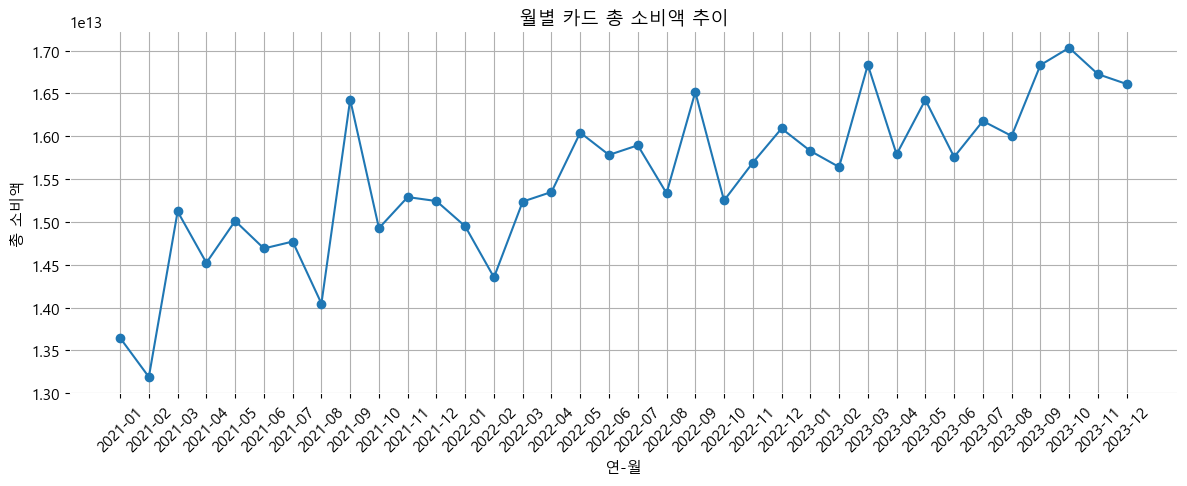

In [92]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정 (윈도우 기본 폰트)
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False


# 연-월 기준 월별 소비 집계
monthly_sales = card_selected_df.groupby(['YEAR', 'MONTH'])['TOTAL_SALES'].sum().reset_index()
monthly_sales['YM'] = monthly_sales['YEAR'].astype(str) + '-' + monthly_sales['MONTH'].astype(str).str.zfill(2)

# 시각화
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales['YM'], monthly_sales['TOTAL_SALES'], marker='o')
plt.xticks(rotation=45)
plt.title("월별 카드 총 소비액 추이")
plt.xlabel("연-월")
plt.ylabel("총 소비액")
plt.grid(True)
plt.tight_layout()
plt.show()


### 2. 성별 + 연령대별 소비 비교

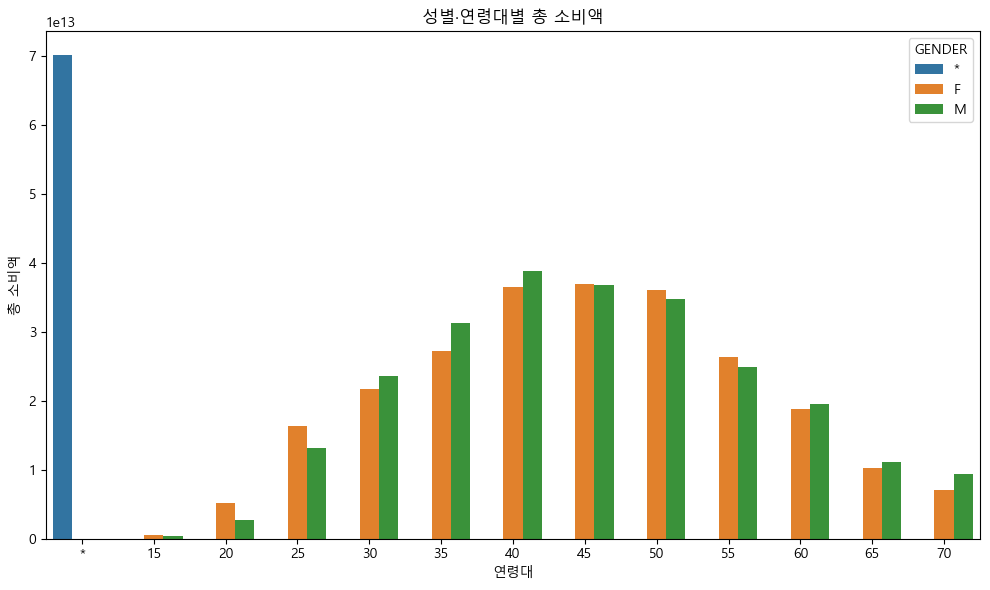

In [57]:
import seaborn as sns

# 집계
age_gender_sales = card_selected_df.groupby(['GENDER', 'AGE_GROUP'])['TOTAL_SALES'].sum().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=age_gender_sales, x='AGE_GROUP', y='TOTAL_SALES', hue='GENDER')
plt.title("성별·연령대별 총 소비액")
plt.xlabel("연령대")
plt.ylabel("총 소비액")
plt.tight_layout()
plt.show()


### 3. 시간대별 커피 소비량 분석

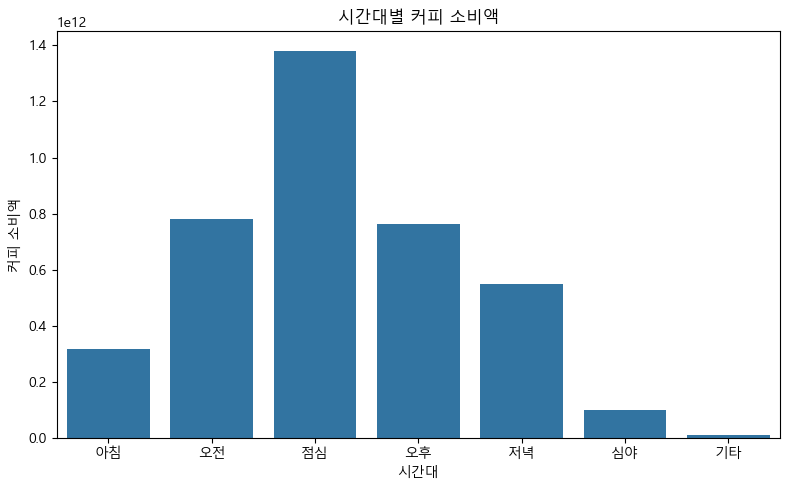

In [60]:
time_coffee = card_selected_df.groupby('TIME_SLOT')['COFFEE_SALES'].sum().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=time_coffee, x='TIME_SLOT', y='COFFEE_SALES', order=['아침', '오전', '점심', '오후', '저녁', '심야', '기타'])
plt.title("시간대별 커피 소비액")
plt.xlabel("시간대")
plt.ylabel("커피 소비액")
plt.tight_layout()
plt.show()


#### 4. 라이프 스타일별 커피 소비 비교

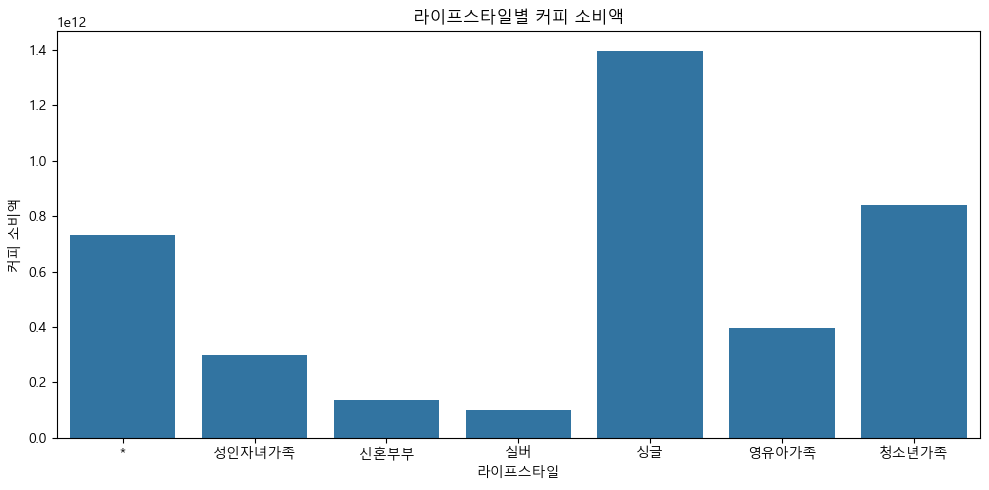

In [63]:
lifestyle_coffee = card_selected_df.groupby('LIFESTYLE')['COFFEE_SALES'].sum().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(data=lifestyle_coffee, x='LIFESTYLE', y='COFFEE_SALES')
plt.title("라이프스타일별 커피 소비액")
plt.xlabel("라이프스타일")
plt.ylabel("커피 소비액")
plt.tight_layout()
plt.show()


### 5. 구, 동 별 커피 소비액 체크

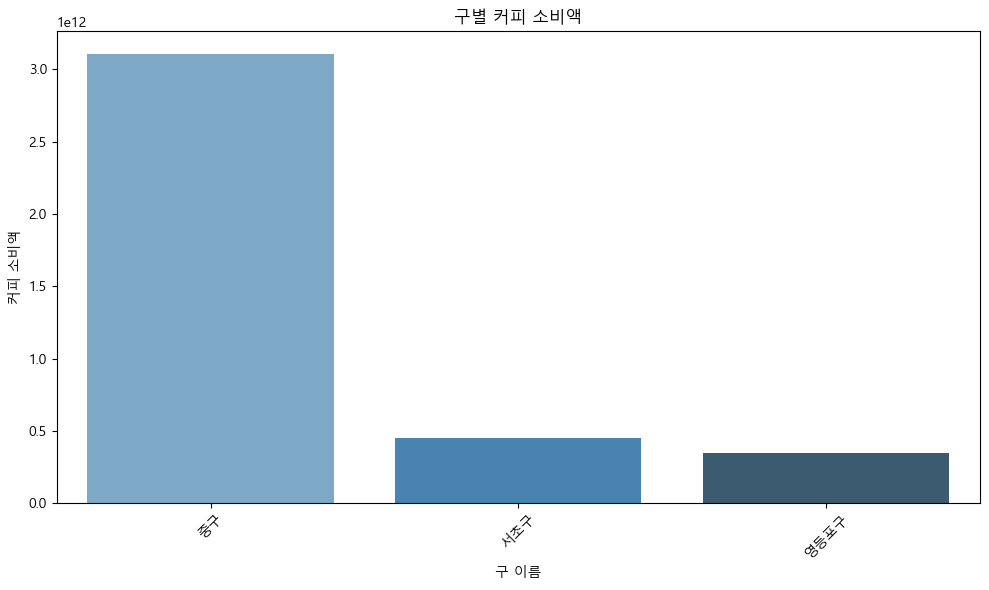

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 구별 커피 소비액 합계
city_group = card_selected_df.groupby('CITY_NAME')['COFFEE_SALES'].sum().reset_index().sort_values('COFFEE_SALES', ascending=False)

# 막대 그래프
plt.figure(figsize=(10, 6))
sns.barplot(data=city_group, x='CITY_NAME', y='COFFEE_SALES', palette='Blues_d')
plt.title('구별 커피 소비액')
plt.xlabel('구 이름')
plt.ylabel('커피 소비액')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [76]:
!pip install squarify

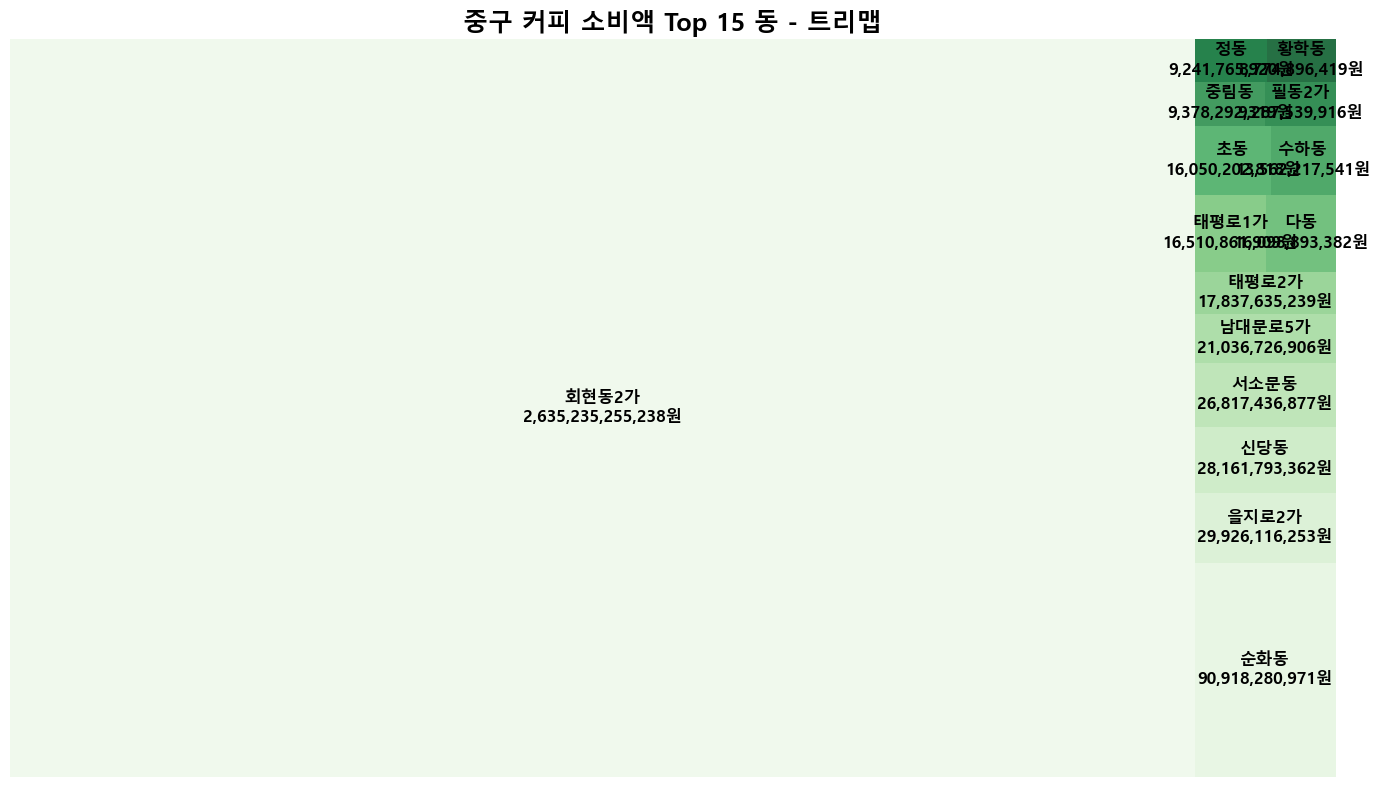

In [131]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 중구 데이터 필터 + 커피 소비량 합계
junggu_df = card_selected_df[card_selected_df['CITY_NAME'] == '중구']
grouped = junggu_df.groupby('DISTRICT_NAME')['COFFEE_SALES'].sum().reset_index()
grouped = grouped[grouped['COFFEE_SALES'] > 0]

# 상위 15개만 추출
top15 = grouped.sort_values('COFFEE_SALES', ascending=False).head(15)

# 라벨: "동이름\n소비액"
top15['label'] = top15['DISTRICT_NAME'] + '\n' + top15['COFFEE_SALES'].apply(lambda x: f"{int(x):,}원")

# 색상 지정
colors = sns.color_palette("Greens", len(top15))

# 트리맵 그리기
plt.figure(figsize=(14, 8))
squarify.plot(
    sizes=top15['COFFEE_SALES'],
    label=top15['label'],
    color=colors,
    alpha=0.85,
    text_kwargs={'fontsize':12, 'weight':'bold'}
)
plt.title('중구 커피 소비액 Top 15 동 - 트리맵', fontsize=18, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


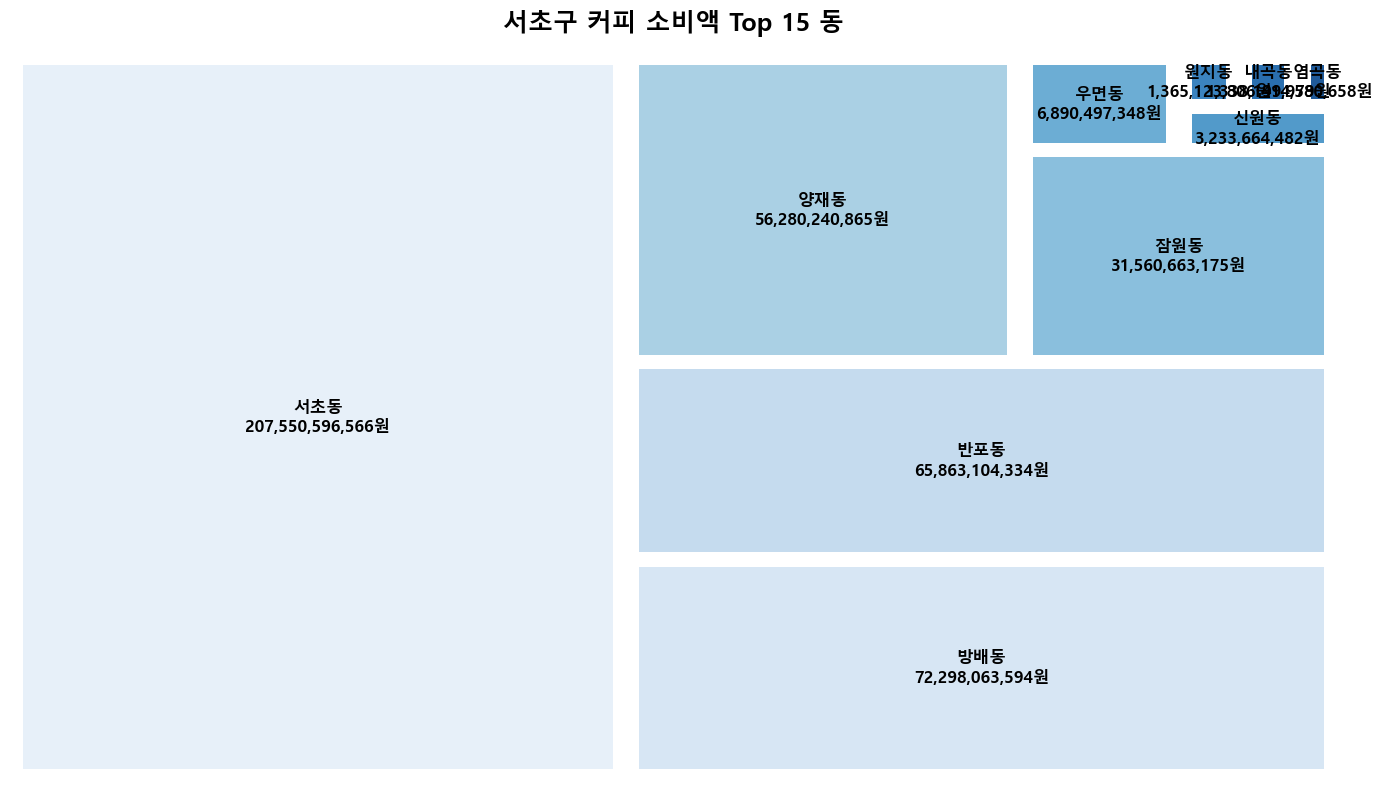

In [129]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 서초구 필터링
seocho_df = card_selected_df[card_selected_df['CITY_NAME'] == '서초구']
grouped = seocho_df.groupby('DISTRICT_NAME')['COFFEE_SALES'].sum().reset_index()
grouped = grouped[grouped['COFFEE_SALES'] > 0]

# 상위 15개 추출
top15 = grouped.sort_values('COFFEE_SALES', ascending=False).head(15)
top15['label'] = top15['DISTRICT_NAME'] + '\n' + top15['COFFEE_SALES'].apply(lambda x: f"{int(x):,}원")

# 컬러 (Viridis)
colors = sns.color_palette("Blues", len(top15))

# 한글 지원 폰트
plt.rcParams.update({
    'font.family': 'Malgun Gothic',
    'font.size': 11,
    'axes.edgecolor': 'white'
})

# 트리맵 시각화 (글씨 굵게 + 검정색)
plt.figure(figsize=(14, 8), facecolor='white')
squarify.plot(
    sizes=top15['COFFEE_SALES'],
    label=top15['label'],
    color=colors,
    alpha=0.9,
    pad=True,
    text_kwargs={'fontsize':12, 'weight': 'bold', 'color': 'black'}
)
plt.title('서초구 커피 소비액 Top 15 동', fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


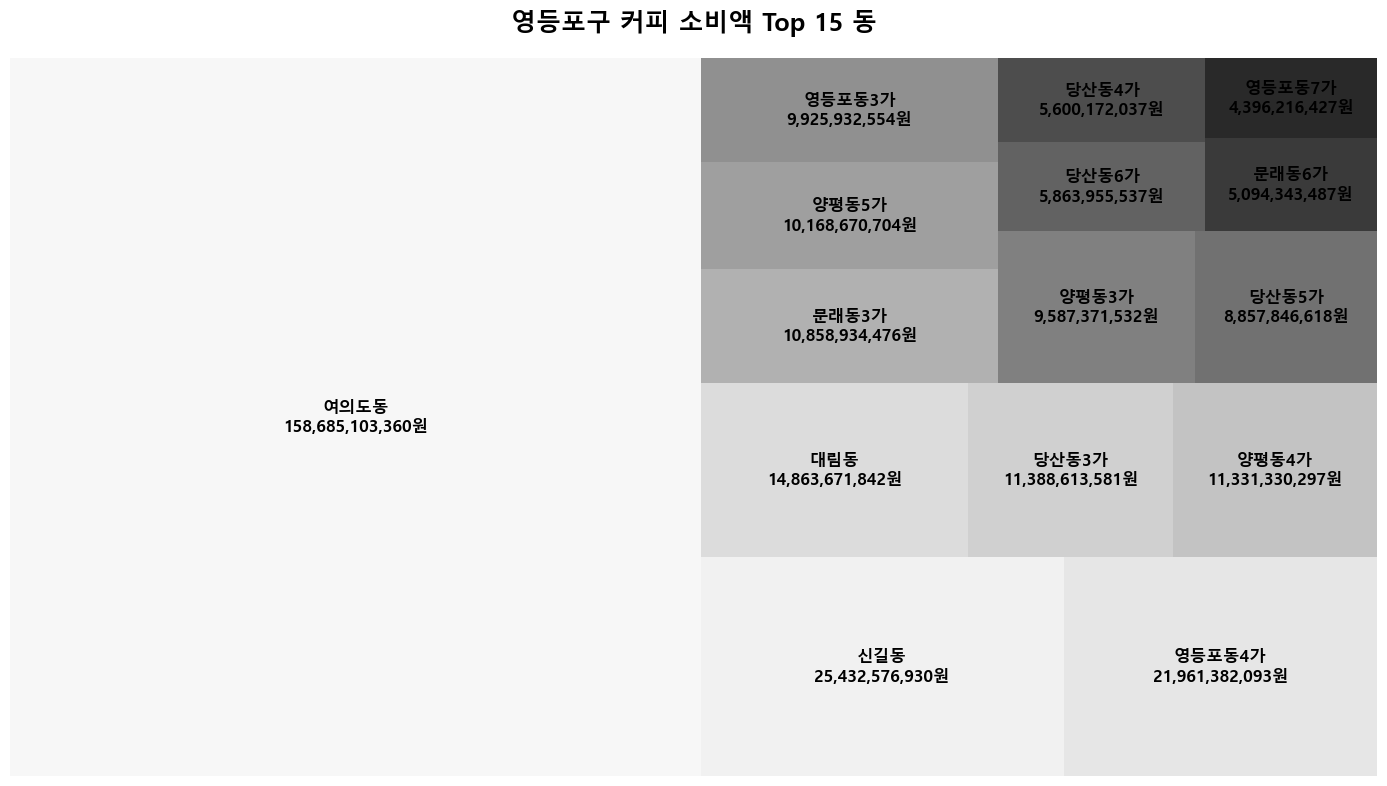

In [137]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 영등포구 필터링 및 집계
ydp_df = card_selected_df[card_selected_df['CITY_NAME'] == '영등포구']
grouped = ydp_df.groupby('DISTRICT_NAME')['COFFEE_SALES'].sum().reset_index()
grouped = grouped[grouped['COFFEE_SALES'] > 0]

# 상위 15개 동 추출
top15 = grouped.sort_values('COFFEE_SALES', ascending=False).head(15)
top15['label'] = top15['DISTRICT_NAME'] + '\n' + top15['COFFEE_SALES'].apply(lambda x: f"{int(x):,}원")

# 컬러 팔레트
colors = sns.color_palette("Greys", len(top15))

# 한글 폰트 (Windows 호환)
plt.rcParams.update({
    'font.family': 'Malgun Gothic',
    'font.size': 11,
    'axes.edgecolor': 'white'
})

# 트리맵 시각화
plt.figure(figsize=(14, 8), facecolor='white')
squarify.plot(
    sizes=top15['COFFEE_SALES'],
    label=top15['label'],
    color=colors,
    alpha=0.9,
    pad=False,
    text_kwargs={'fontsize':12, 'weight': 'bold', 'color': 'black'}
)
plt.title('영등포구 커피 소비액 Top 15 동', fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


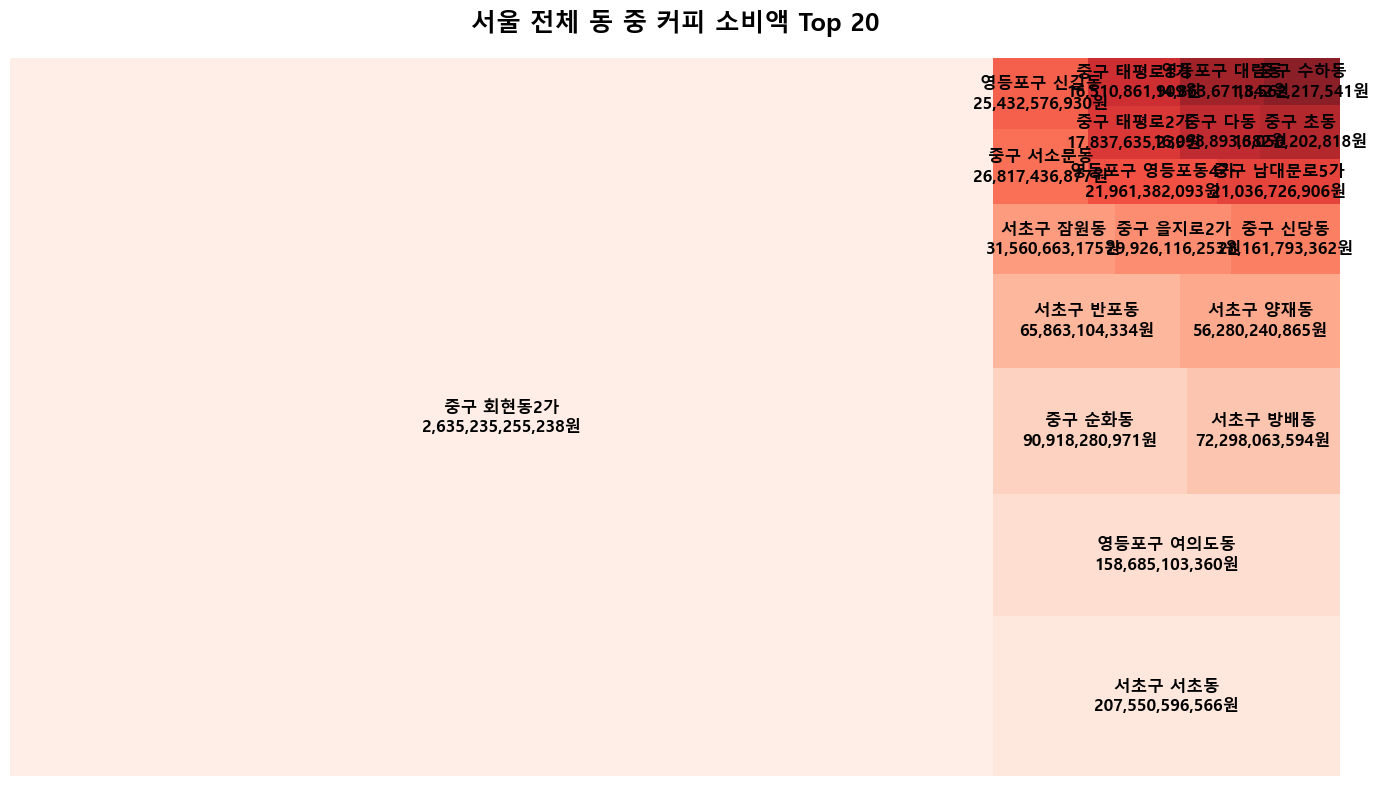

In [139]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 전체 동 기준 소비액 합산
grouped = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_SALES'].sum().reset_index()
grouped = grouped[grouped['COFFEE_SALES'] > 0]

# 상위 N개 동 추출
top_n = 20
top_dong = grouped.sort_values('COFFEE_SALES', ascending=False).head(top_n)

# 라벨: 구 + 동 + 소비액
top_dong['label'] = top_dong['CITY_NAME'] + ' ' + top_dong['DISTRICT_NAME'] + '\n' + top_dong['COFFEE_SALES'].apply(lambda x: f"{int(x):,}원")

# 컬러 팔레트
colors = sns.color_palette("Reds", len(top_dong))

# 폰트 설정 (Malgun Gothic + Bold)
plt.rcParams.update({
    'font.family': 'Malgun Gothic',
    'font.size': 11,
    'axes.edgecolor': 'white'
})

# 트리맵 그리기
plt.figure(figsize=(14, 8), facecolor='white')
squarify.plot(
    sizes=top_dong['COFFEE_SALES'],
    label=top_dong['label'],
    color=colors,
    alpha=0.9,
    pad=False,
    text_kwargs={'fontsize':12, 'weight': 'bold', 'color': 'black'}
)
plt.title(f'서울 전체 동 중 커피 소비액 Top {top_n}', fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


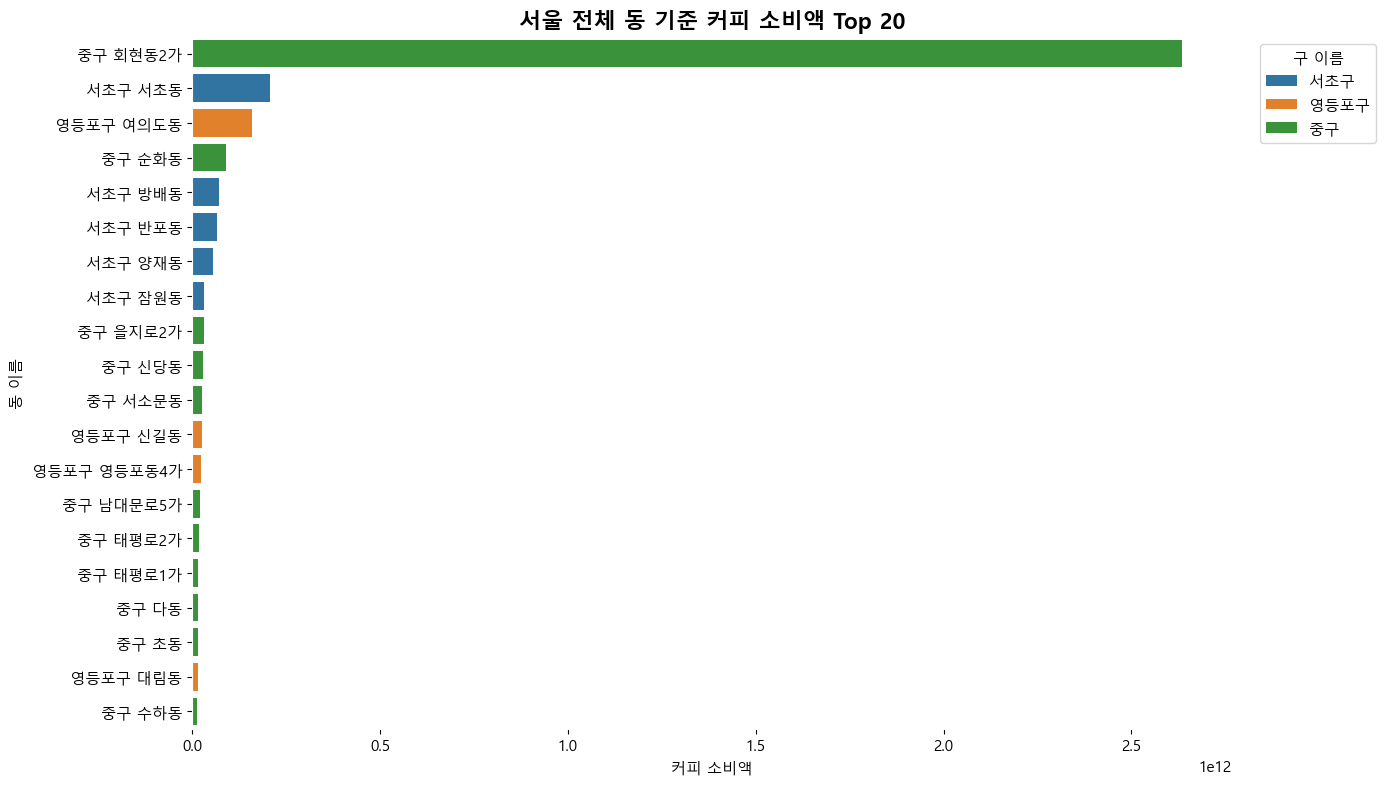

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 전체 동 기준 소비액 집계
grouped = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_SALES'].sum().reset_index()
grouped = grouped[grouped['COFFEE_SALES'] > 0]

# 상위 20개 동 추출
top_n = 20
top_dong = grouped.sort_values('COFFEE_SALES', ascending=False).head(top_n)

# 라벨: 구 + 동 이름 (x축)
top_dong['label'] = top_dong['CITY_NAME'] + ' ' + top_dong['DISTRICT_NAME']

# 구 이름을 범주형으로 바꾸고 palette 매핑
top_dong['CITY_NAME'] = top_dong['CITY_NAME'].astype('category')
palette = dict(zip(top_dong['CITY_NAME'].cat.categories, sns.color_palette('tab10', n_colors=top_dong['CITY_NAME'].nunique())))

# 막대그래프
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_dong,
    x='COFFEE_SALES',
    y='label',
    hue='CITY_NAME',
    dodge=False,
    palette=palette
)
plt.title(f'서울 전체 동 기준 커피 소비액 Top {top_n}', fontsize=16, fontweight='bold')
plt.xlabel('커피 소비액')
plt.ylabel('동 이름')
plt.legend(title='구 이름', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 6. 구별 소비액 체크 

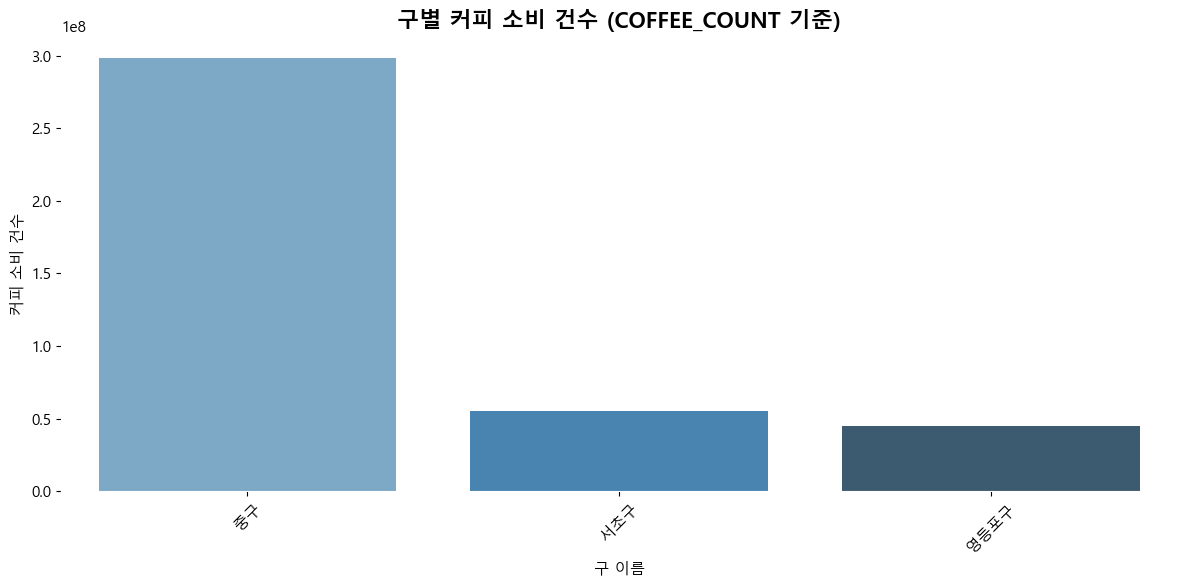

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 구별로 커피 소비 건수 합계 계산
count_by_city = card_selected_df.groupby('CITY_NAME')['COFFEE_COUNT'].sum().reset_index()

# 소비 건수 기준 내림차순 정렬
count_by_city = count_by_city.sort_values('COFFEE_COUNT', ascending=False)

# 막대그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(
    data=count_by_city,
    x='CITY_NAME',
    y='COFFEE_COUNT',
    palette='Blues_d'
)
plt.title('구별 커피 소비 건수 (COFFEE_COUNT 기준)', fontsize=16, fontweight='bold')
plt.xlabel('구 이름')
plt.ylabel('커피 소비 건수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


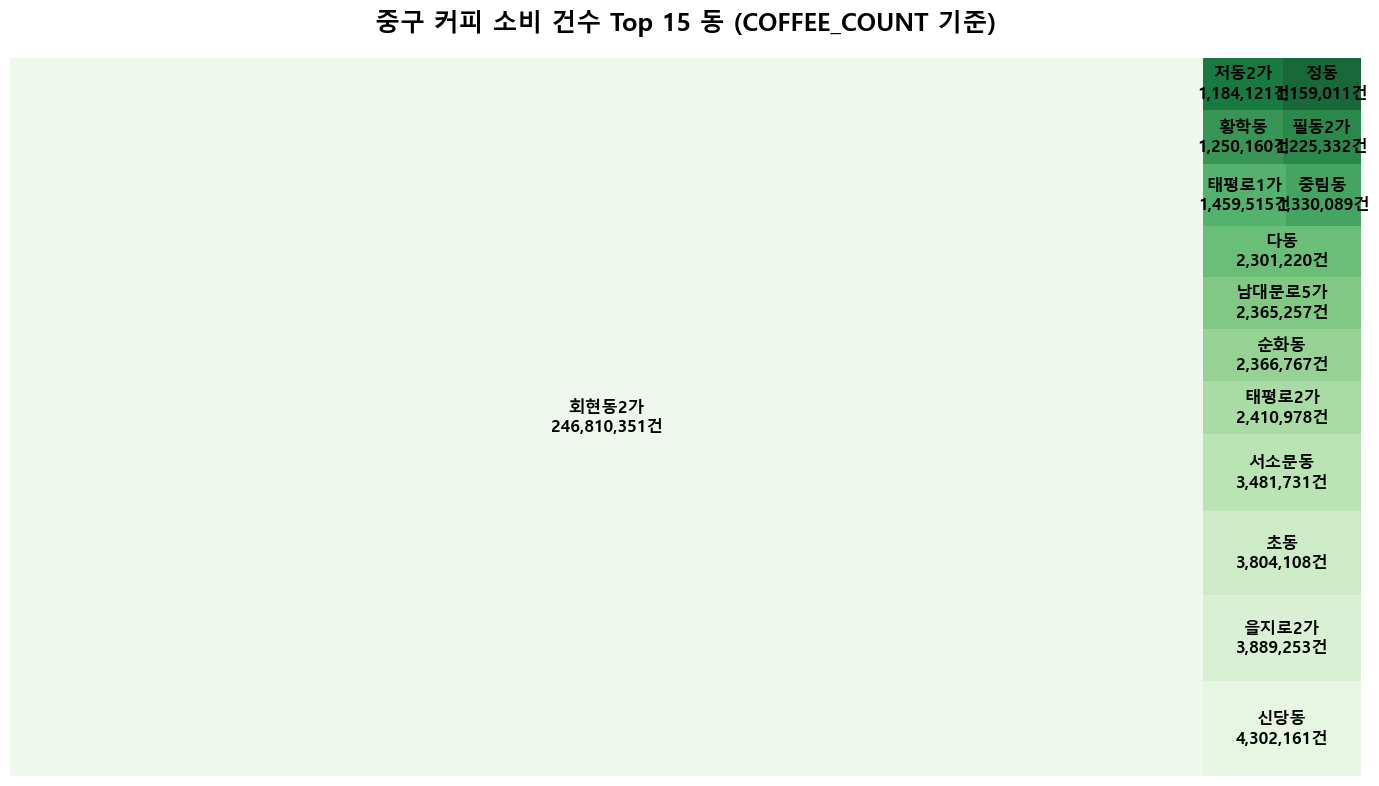

In [141]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 중구 데이터 필터링
junggu_df = card_selected_df[card_selected_df['CITY_NAME'] == '중구']

# 동별 커피 소비 건수 집계
grouped = junggu_df.groupby('DISTRICT_NAME')['COFFEE_COUNT'].sum().reset_index()
grouped = grouped[grouped['COFFEE_COUNT'] > 0]

# 상위 15개 동 추출
top15 = grouped.sort_values('COFFEE_COUNT', ascending=False).head(15)

# 라벨 생성
top15['label'] = top15['DISTRICT_NAME'] + '\n' + top15['COFFEE_COUNT'].apply(lambda x: f"{x:,.0f}건")

# 컬러 팔레트 (세련된 viridis)
colors = sns.color_palette("Greens", len(top15))

# 폰트 설정 (한글 + 가독성)
plt.rcParams.update({
    'font.family': 'Malgun Gothic',
    'font.size': 11,
    'axes.edgecolor': 'white'
})

# 트리맵 시각화
plt.figure(figsize=(14, 8), facecolor='white')
squarify.plot(
    sizes=top15['COFFEE_COUNT'],
    label=top15['label'],
    color=colors,
    alpha=0.9,
    pad=False,
    text_kwargs={'fontsize':12, 'weight': 'bold', 'color': 'black'}
)
plt.title('중구 커피 소비 건수 Top 15 동 (COFFEE_COUNT 기준)', fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


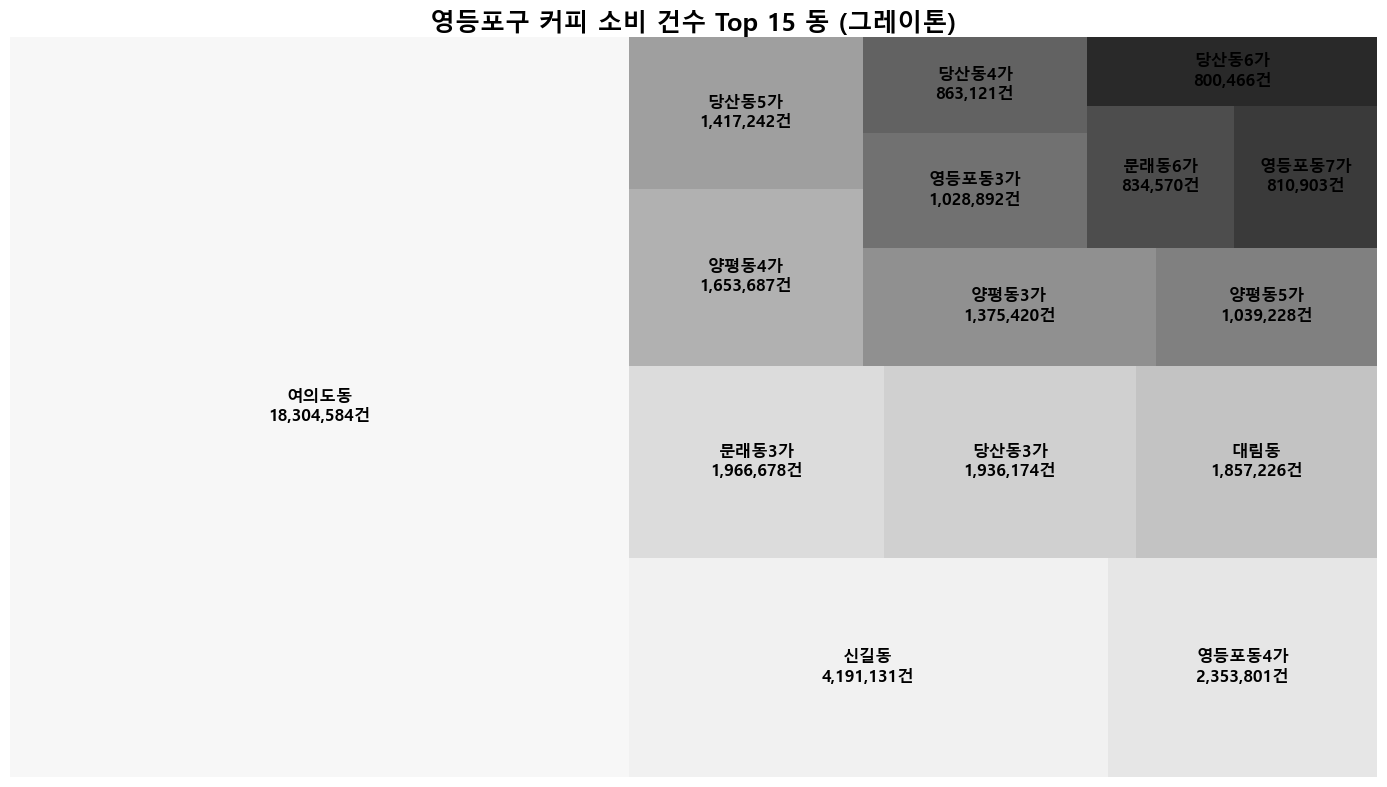

In [135]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 영등포구 필터링 및 소비 건수 합계
ydp_df = card_selected_df[card_selected_df['CITY_NAME'] == '영등포구']
grouped = ydp_df.groupby('DISTRICT_NAME')['COFFEE_COUNT'].sum().reset_index()
grouped = grouped[grouped['COFFEE_COUNT'] > 0]

# 상위 15개 동 추출
top15 = grouped.sort_values('COFFEE_COUNT', ascending=False).head(15)

# 라벨 생성
top15['label'] = top15['DISTRICT_NAME'] + '\n' + top15['COFFEE_COUNT'].apply(lambda x: f"{x:,.0f}건")

# 컬러 팔레트: 그레이스케일
colors = sns.color_palette("Greys", len(top15))

# 폰트 설정 (Windows용 한글 폰트)
plt.rcParams.update({
    'font.family': 'Malgun Gothic',
    'font.size': 11,
    'axes.edgecolor': 'white'
})

# 트리맵 시각화
plt.figure(figsize=(14, 8), facecolor='white')
squarify.plot(
    sizes=top15['COFFEE_COUNT'],
    label=top15['label'],
    color=colors,
    alpha=0.9,
    pad=False,
    text_kwargs={'fontsize':12, 'weight': 'bold', 'color': 'black'}
)
plt.title('영등포구 커피 소비 건수 Top 15 동 (그레이톤)', fontsize=18, fontweight='bold', pad=0)
plt.axis('off')
plt.tight_layout()
plt.show()


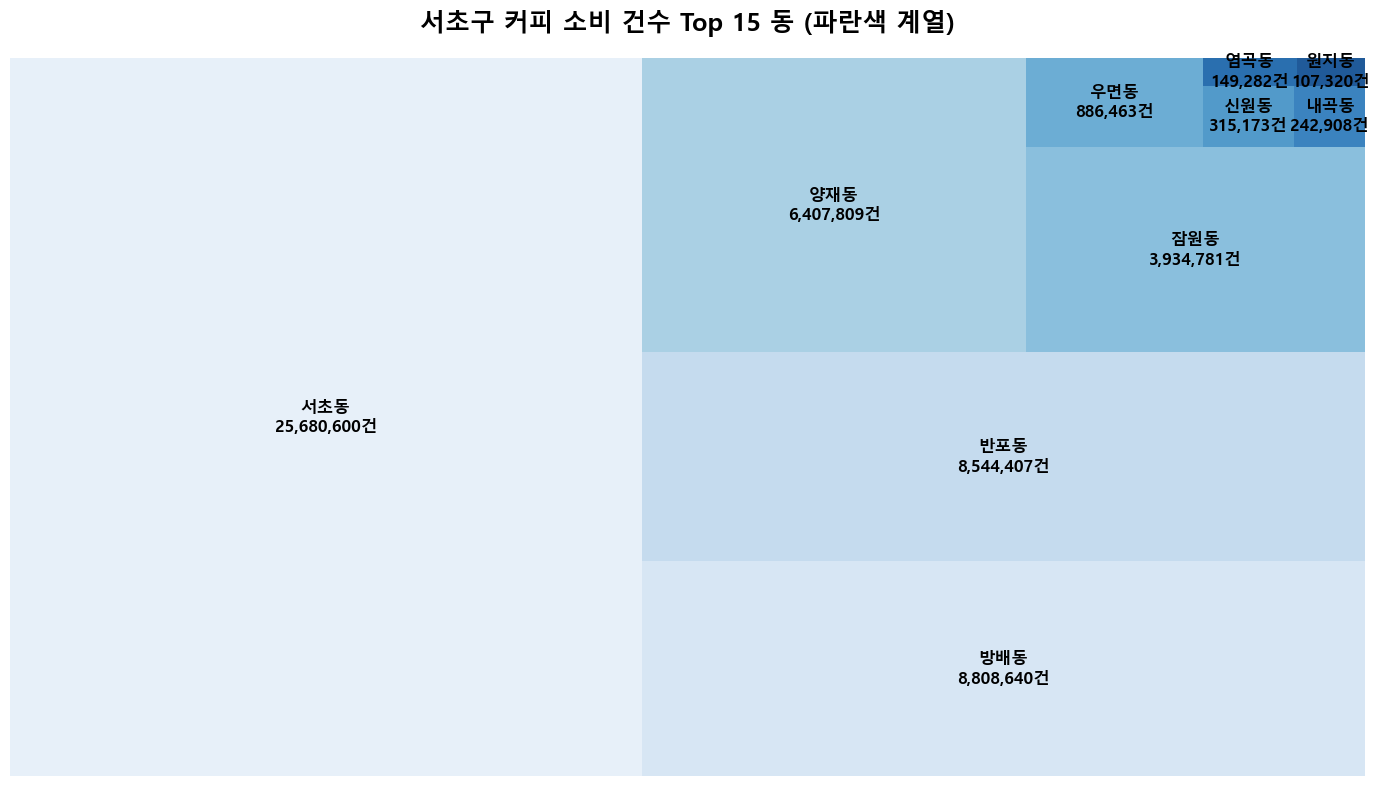

In [143]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 서초구 필터링 및 소비 건수 집계
seocho_df = card_selected_df[card_selected_df['CITY_NAME'] == '서초구']
grouped = seocho_df.groupby('DISTRICT_NAME')['COFFEE_COUNT'].sum().reset_index()
grouped = grouped[grouped['COFFEE_COUNT'] > 0]

# 상위 15개 동 추출
top15 = grouped.sort_values('COFFEE_COUNT', ascending=False).head(15)

# 라벨 생성
top15['label'] = top15['DISTRICT_NAME'] + '\n' + top15['COFFEE_COUNT'].apply(lambda x: f"{x:,.0f}건")

# 색상: 고급 파란색 계열
colors = sns.color_palette("Blues", len(top15))

# 폰트 설정
plt.rcParams.update({
    'font.family': 'Malgun Gothic',
    'font.size': 11,
    'axes.edgecolor': 'white'
})

# 트리맵 그리기
plt.figure(figsize=(14, 8), facecolor='white')
squarify.plot(
    sizes=top15['COFFEE_COUNT'],
    label=top15['label'],
    color=colors,
    alpha=0.9,
    pad=False,
    text_kwargs={'fontsize':12, 'weight': 'bold', 'color': 'black'}
)
plt.title('서초구 커피 소비 건수 Top 15 동 (파란색 계열)', fontsize=18, fontweight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()


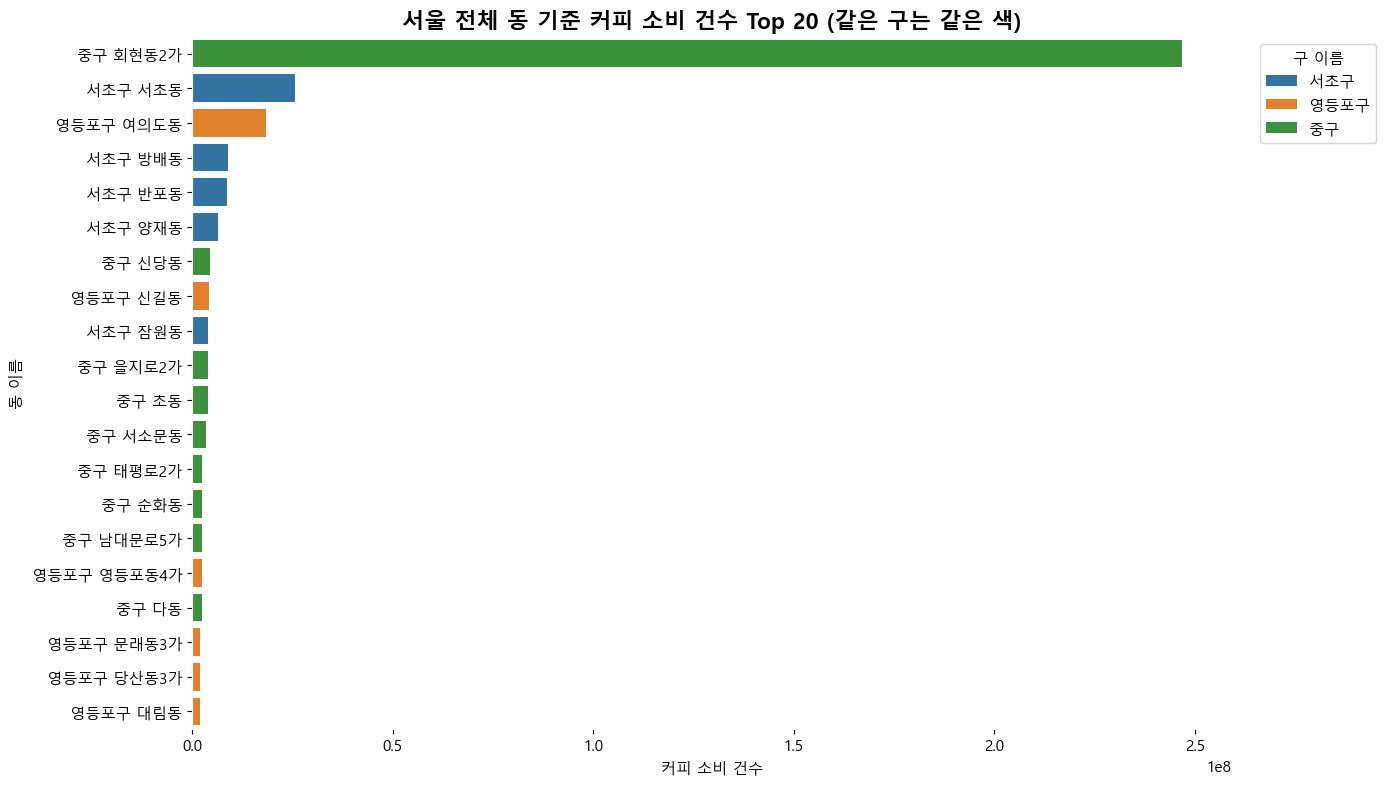

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. 전체 동 기준 커피 소비 건수 집계
grouped = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_COUNT'].sum().reset_index()
grouped = grouped[grouped['COFFEE_COUNT'] > 0]

# 2. 상위 20개 동 추출
top_n = 20
top20 = grouped.sort_values('COFFEE_COUNT', ascending=False).head(top_n)

# 3. 라벨: "구 동"
top20['label'] = top20['CITY_NAME'] + ' ' + top20['DISTRICT_NAME']

# 4. 구 이름 기준으로 color palette 만들기
top20['CITY_NAME'] = top20['CITY_NAME'].astype('category')
palette = dict(zip(
    top20['CITY_NAME'].cat.categories,
    sns.color_palette('tab10', n_colors=top20['CITY_NAME'].nunique())
))

# 5. 막대그래프 시각화
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top20,
    x='COFFEE_COUNT',
    y='label',
    hue='CITY_NAME',
    dodge=False,
    palette=palette
)
plt.title('서울 전체 동 기준 커피 소비 건수 Top 20 (같은 구는 같은 색)', fontsize=16, fontweight='bold')
plt.xlabel('커피 소비 건수')
plt.ylabel('동 이름')
plt.legend(title='구 이름', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [147]:
list(card_selected_df.columns)


['CITY_NAME',
 'DISTRICT_NAME',
 'CARD_TYPE',
 'WEEKDAY_WEEKEND',
 'GENDER',
 'AGE_GROUP',
 'TIME_SLOT',
 'LIFESTYLE',
 'TOTAL_SALES',
 'COFFEE_SALES',
 'TOTAL_COUNT',
 'COFFEE_COUNT',
 'YEAR',
 'MONTH']

In [160]:
sales_top20 = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_SALES'].sum().reset_index()
sales_top20 = sales_top20.sort_values('COFFEE_SALES', ascending=False).head(20)

count_top20 = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_COUNT'].sum().reset_index()
count_top20 = count_top20.sort_values('COFFEE_COUNT', ascending=False).head(20)


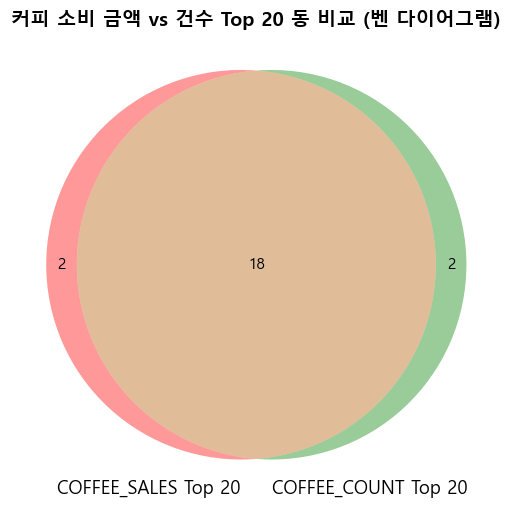

In [164]:
# 설치가 안 되어 있다면 먼저 설치해 주세요
# !pip install matplotlib-venn

from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# 폰트 설정 (한글 깨짐 방지 - 환경에 맞게 수정 가능)

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows 사용자용
# plt.rcParams['font.family'] = 'NanumGothic'  # Colab 등

# 동 이름 추출 (sales_top20, count_top20이 미리 정의돼 있어야 함)
sales_top20_dongs = set(sales_top20['DISTRICT_NAME'])
count_top20_dongs = set(count_top20['DISTRICT_NAME'])

# 벤 다이어그램 시각화
plt.figure(figsize=(8, 6))
venn2(
    subsets=(sales_top20_dongs, count_top20_dongs),
    set_labels=('COFFEE_SALES Top 20', 'COFFEE_COUNT Top 20')
)
plt.title('커피 소비 금액 vs 건수 Top 20 동 비교 (벤 다이어그램)', fontsize=14, fontweight='bold')
plt.show()


### 7. 소비량 VS 소비액 비교 

In [168]:
# 순위 테이블 생성
sales_top20 = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_SALES'].sum().reset_index()
sales_top20 = sales_top20.sort_values('COFFEE_SALES', ascending=False).head(20)
sales_top20['RANK_SALES'] = range(1, 21)

count_top20 = card_selected_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['COFFEE_COUNT'].sum().reset_index()
count_top20 = count_top20.sort_values('COFFEE_COUNT', ascending=False).head(20)
count_top20['RANK_COUNT'] = range(1, 21)

# 병합 및 순위 차이
merged_rank = pd.merge(sales_top20, count_top20, on=['CITY_NAME', 'DISTRICT_NAME'], how='outer')
merged_rank['RANK_GAP'] = merged_rank['RANK_SALES'] - merged_rank['RANK_COUNT']

# 테이블 정리
rank_table = merged_rank[['CITY_NAME', 'DISTRICT_NAME', 'RANK_SALES', 'RANK_COUNT', 'RANK_GAP']] \
    .sort_values(by='RANK_SALES', na_position='last')

# 스타일링: 양수는 빨강, 음수는 파랑, 0은 회색
def color_rank_gap(val):
    if pd.isna(val):
        return 'color: gray'
    elif val > 0:
        return 'color: red; font-weight: bold'
    elif val < 0:
        return 'color: blue; font-weight: bold'
    else:
        return 'color: gray; font-weight: bold'

# 스타일 적용
styled_table = rank_table.style \
    .set_caption("💡 COFFEE_SALES vs COFFEE_COUNT 순위 비교 테이블") \
    .applymap(color_rank_gap, subset=['RANK_GAP']) \
    .format({'RANK_SALES': '{:.0f}', 'RANK_COUNT': '{:.0f}', 'RANK_GAP': '{:+.0f}'}) \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'center')]
    }])

styled_table


,CITY_NAME,DISTRICT_NAME,RANK_SALES,RANK_COUNT,RANK_GAP
21,중구,회현동2가,1,1,+0
2,서초구,서초동,2,2,+0
9,영등포구,여의도동,3,3,+0
15,중구,순화동,4,14,-10
1,서초구,방배동,5,4,+1
0,서초구,반포동,6,5,+1
3,서초구,양재동,7,6,+1
4,서초구,잠원동,8,9,-1
17,중구,을지로2가,9,10,-1
16,중구,신당동,10,7,+3


- RANK_SALES : 커피 소비 금액 기준 순위 (1등이 가장 많이 씀)
- RANK_COUNT : 커피 소비 횟수 기준 순위 (1등이 가장 자주 마심)
- RANK_GAP = RANK_SALES - RANK_COUNT
  - (+) : 비싼 커피 많이 삼
      - 신길동 : 건수는 8위지만 금액은 12위 -> 커피 값이 비쌌을 가능성
      - 양재동: 자주 마시진 않았지만 소비 금액은 약간 더 높음
        => 프리미엄 커피 브랜드, 테이크아웃보다 매장에서 즐기는 소비 형태일 수도 있음 
  - (-) : 자주 마셨지만 저렴함
      - 순화동 : 10단계 낮음 -> 자주 마셨지만 단가 낮음 (편의점, 프랜차이즈 ?)
      - 초등 : 단가 낮고 자주 마신 지역으로 추정
        => 편의점 커피, 프랜차이즘 다회 방문 중심일 가능성
  - 0 : 상권의 규모가 소비 행동과 일치하는 고소득/고활동 동네일 가능성 


## Float data

### 1. 일단 데이터 전처리 

In [276]:
# 출력 (DataFrame 형식)
from IPython.display import display
float_df = float_df.to_pandas()
display(float_df)

,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,11560,11560126,202308,H,F,50,T06,121.12,9.30,23.27
1,11,11560,11560126,202308,H,M,30,T12,125.13,19.91,71.18
2,11,11560,11560126,202308,W,F,10,T15,190.06,2.53,59.34
3,11,11560,11560126,202308,W,M,55,T18,88.27,23.48,56.46
4,11,11560,11560126,202308,W,F,35,T24,203.33,6.04,21.15
...,...,...,...,...,...,...,...,...,...,...,...
1546267,11,11140,11140130,202306,W,F,45,T06,19.23,11.28,9.89
1546268,11,11140,11140130,202306,W,M,20,T21,8.89,1.63,9.02
1546269,11,11140,11140130,202306,H,M,65,T18,19.11,1.82,11.50
1546270,11,11140,11140130,202306,W,F,70,T24,23.92,0.00,3.45


In [278]:
# 시간대 매핑 딕셔너리 (CODE_ID == 'M03')
time_slot_map = {
    'T06': '아침',
    'T09': '오전',
    'T12': '점심',
    'T15': '오후',
    'T18': '저녁',
    'T21': '심야',
    'T24': '기타'
}


# 딕셔너리를 이용한 값 치환
float_df['TIME_SLOT'] = float_df['TIME_SLOT'].replace(time_slot_map)

from IPython.display import display
display(float_df.head())




,PROVINCE_CODE,CITY_CODE,DISTRICT_CODE,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,11560,11560126,202308,H,F,50,아침,121.12,9.30,23.27
1,11,11560,11560126,202308,H,M,30,점심,125.13,19.91,71.18
2,11,11560,11560126,202308,W,F,10,오후,190.06,2.53,59.34
3,11,11560,11560126,202308,W,M,55,저녁,88.27,23.48,56.46
4,11,11560,11560126,202308,W,F,35,기타,203.33,6.04,21.15


In [280]:
# 동네 명칭 바꾸기 
# 1. Snowflake에서 m_scco_mst 테이블 불러오기
mst_df = session.table("M_SCCO_MST").to_pandas()

# 2. 매핑용 딕셔너리 생성
city_map = dict(zip(mst_df['CITY_CODE'], mst_df['CITY_KOR_NAME']))
district_map = dict(zip(mst_df['DISTRICT_CODE'], mst_df['DISTRICT_KOR_NAME']))

# 3. 컬럼 타입을 str로 변환 (안 하면 KeyError 날 수 있음)
float_df['CITY_CODE'] = float_df['CITY_CODE'].astype(str)
float_df['DISTRICT_CODE'] = float_df['DISTRICT_CODE'].astype(str)

# 4. 값 치환
float_df['CITY_CODE'] = float_df['CITY_CODE'].replace(city_map)
float_df['DISTRICT_CODE'] = float_df['DISTRICT_CODE'].replace(district_map)

float_df = float_df.rename(columns={
    'CITY_CODE': 'CITY_NAME',
    'DISTRICT_CODE': 'DISTRICT_NAME'
})

from IPython.display import display
display(float_df[['CITY_NAME', 'DISTRICT_NAME']].head())



,CITY_NAME,DISTRICT_NAME
0,영등포구,양평동2가
1,영등포구,양평동2가
2,영등포구,양평동2가
3,영등포구,양평동2가
4,영등포구,양평동2가


In [281]:
display(float_df.head())

,PROVINCE_CODE,CITY_NAME,DISTRICT_NAME,STANDARD_YEAR_MONTH,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION
0,11,영등포구,양평동2가,202308,H,F,50,아침,121.12,9.30,23.27
1,11,영등포구,양평동2가,202308,H,M,30,점심,125.13,19.91,71.18
2,11,영등포구,양평동2가,202308,W,F,10,오후,190.06,2.53,59.34
3,11,영등포구,양평동2가,202308,W,M,55,저녁,88.27,23.48,56.46
4,11,영등포구,양평동2가,202308,W,F,35,기타,203.33,6.04,21.15


In [282]:
float_df = float_df.drop(columns=['PROVINCE_CODE'])

In [283]:
# 문자열로 변환 (혹시 숫자형일 수도 있으니)
float_df['STANDARD_YEAR_MONTH'] = float_df['STANDARD_YEAR_MONTH'].astype(str)

# 연도, 월 분리
float_df['YEAR'] = float_df['STANDARD_YEAR_MONTH'].str[:4]
float_df['MONTH'] = float_df['STANDARD_YEAR_MONTH'].str[4:6]

display(float_df[['STANDARD_YEAR_MONTH', 'YEAR', 'MONTH']].head())



,STANDARD_YEAR_MONTH,YEAR,MONTH
0,202308,2023,08
1,202308,2023,08
2,202308,2023,08
3,202308,2023,08
4,202308,2023,08


In [284]:
float_df = float_df.drop(columns=['STANDARD_YEAR_MONTH'])

In [285]:
display(float_df.head())

,CITY_NAME,DISTRICT_NAME,WEEKDAY_WEEKEND,GENDER,AGE_GROUP,TIME_SLOT,RESIDENTIAL_POPULATION,WORKING_POPULATION,VISITING_POPULATION,YEAR,MONTH
0,영등포구,양평동2가,H,F,50,아침,121.12,9.30,23.27,2023,08
1,영등포구,양평동2가,H,M,30,점심,125.13,19.91,71.18,2023,08
2,영등포구,양평동2가,W,F,10,오후,190.06,2.53,59.34,2023,08
3,영등포구,양평동2가,W,M,55,저녁,88.27,23.48,56.46,2023,08
4,영등포구,양평동2가,W,F,35,기타,203.33,6.04,21.15,2023,08


## 시각화
### 1. 동별 시간대별 유동인구 히트맵

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# NaN 제거
weekday_df = float_df.dropna(subset=['WEEKDAY_WEEKEND', 'VISITING_POPULATION'])

# 평일/주말 기준 총 방문 인구 계산
weekday_summary = weekday_df.groupby('WEEKDAY_WEEKEND')['VISITING_POPULATION'].sum().reset_index()

# 레이블 정리
weekday_summary['WEEKDAY_WEEKEND'] = weekday_summary['WEEKDAY_WEEKEND'].map({'W': '평일', 'H': '주말'})

# 시각화
fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=weekday_summary, x='WEEKDAY_WEEKEND', y='VISITING_POPULATION', palette='Set2', ax=ax)

# y축 단위를 백만(M)으로 표시
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

plt.title('📅 평일 vs 주말 방문 인구 비교', fontsize=16, fontweight='bold')
plt.xlabel('')
plt.ylabel('총 방문 인구 수 (단위: 백만)', fontsize=12)
plt.tight_layout()
plt.show()

# 데이터 확인
print(weekday_summary)


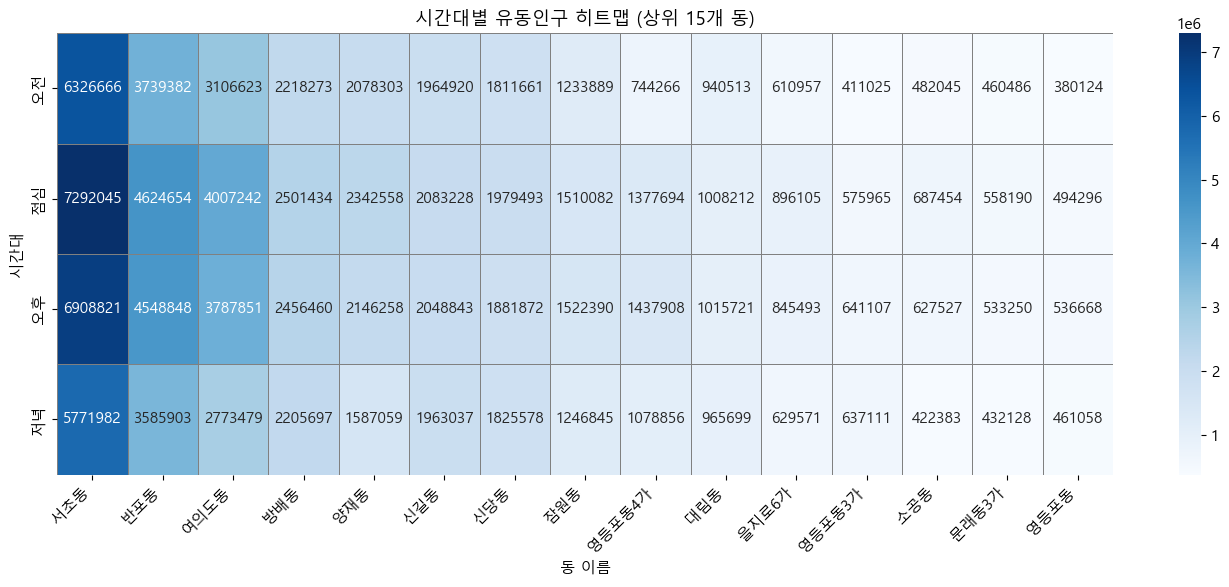

In [304]:
# 5. 상위 15개 동별 시간대 유동인구 히트맵
heatmap_df = float_df.groupby(['TIME_SLOT', 'DISTRICT_NAME'])['VISITING_POPULATION'].sum().unstack()
top15_dongs = heatmap_df.sum().sort_values(ascending=False).head(15).index
heatmap_df = heatmap_df[top15_dongs]

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_df, cmap='Blues', annot=True, fmt=".0f", linewidths=.5, linecolor='gray')
plt.title('시간대별 유동인구 히트맵 (상위 15개 동)')
plt.xlabel('동 이름')
plt.ylabel('시간대')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


📌 (1) 시간대별 패턴 파악 점심, 오후, 저녁에 진한 색이 집중되면: → 해당 동은 유동인구가 주간에 많고 상업시설 또는 오피스가 밀집

아침부터 진하게 시작되는 동이 있다면: → 출근/통학 시작 지점일 가능성

📌 (2) 동별 시간대 집중도 비교 예: 서초동은 점심과 저녁에 진하다면: → 직장인 + 외식 중심지

예: 문래동이 오후에 가장 짙다면: → 카페나 상가 방문 중심지

📌 (3) 시간대 간 유동 분산 여부 특정 동이 모든 시간대에 비슷한 색 → 전일 유동인구가 지속됨

특정 시간대만 짙다면 → 시간대 특화 지역

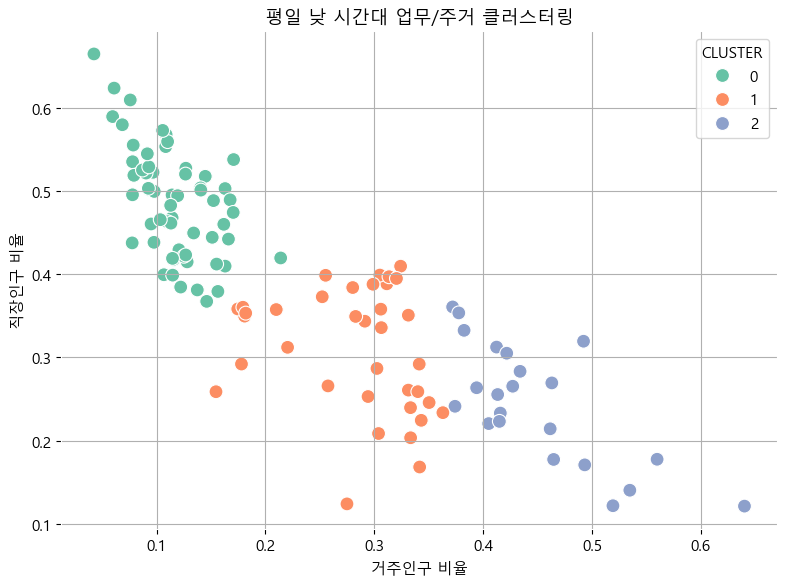

In [260]:
# 6. 평일 낮 클러스터링
subset_df = float_df[(float_df['TIME_SLOT'].isin(['오전', '점심', '오후'])) & (float_df['WEEKDAY_WEEKEND'] == 'W')].copy()
cluster_df = subset_df.groupby('DISTRICT_NAME')[['RESIDENTIAL_POPULATION', 'WORKING_POPULATION', 'VISITING_POPULATION']].mean()
total = cluster_df.sum(axis=1)
cluster_df['res_rate'] = cluster_df['RESIDENTIAL_POPULATION'] / total
cluster_df['work_rate'] = cluster_df['WORKING_POPULATION'] / total
cluster_df['visit_rate'] = cluster_df['VISITING_POPULATION'] / total

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_df['CLUSTER'] = kmeans.fit_predict(cluster_df[['res_rate', 'work_rate', 'visit_rate']])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=cluster_df, x='res_rate', y='work_rate', hue='CLUSTER', palette='Set2', s=100)
plt.title('평일 낮 시간대 업무/주거 클러스터링')
plt.xlabel('거주인구 비율')
plt.ylabel('직장인구 비율')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_12940\2912221482.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



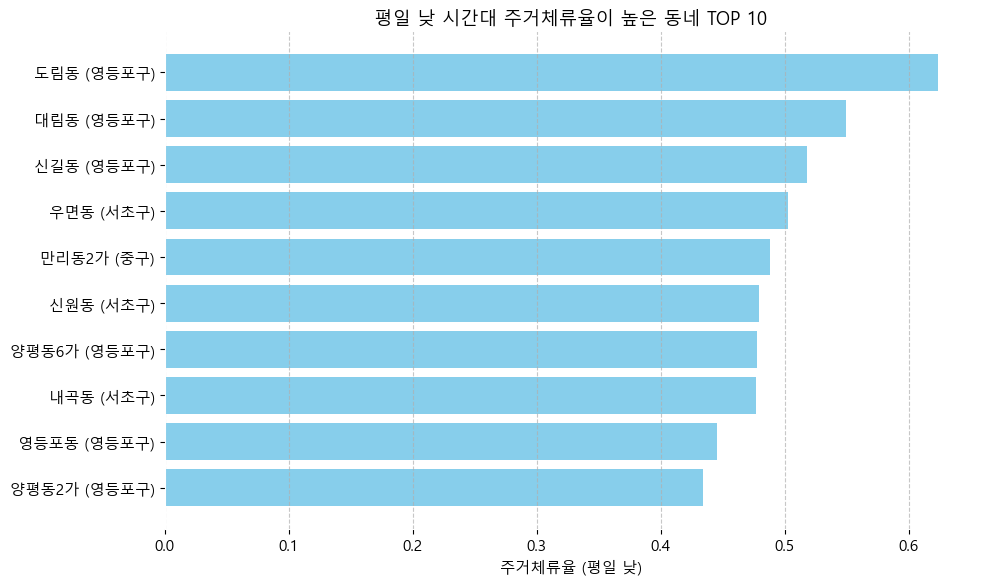

In [322]:
# 주거 체류율 계산 
import pandas as pd
import matplotlib.pyplot as plt

# 1. 평일 낮 데이터 필터링 (예: 점심, 오후 시간대)
daytime_slots = ['점심', '오후']
weekday_df = float_df[(float_df['WEEKDAY_WEEKEND'] == 'W') & (float_df['TIME_SLOT'].isin(daytime_slots))]

# 2. 주거체류율 계산
weekday_df['TOTAL_POPULATION'] = (
    weekday_df['RESIDENTIAL_POPULATION'] +
    weekday_df['WORKING_POPULATION'] +
    weekday_df['VISITING_POPULATION']
)

# 0으로 나누는 경우 방지
weekday_df = weekday_df[weekday_df['TOTAL_POPULATION'] > 0]

# 주거체류율 추가
weekday_df['RESIDENTIAL_RATIO'] = weekday_df['RESIDENTIAL_POPULATION'] / weekday_df['TOTAL_POPULATION']

# 3. 행정동 단위로 평균 주거체류율 계산
grouped = weekday_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['RESIDENTIAL_RATIO'].mean().reset_index()

# 4. 상위 N개 (예: TOP 10)
top_n = grouped.sort_values(by='RESIDENTIAL_RATIO', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_n['DISTRICT_NAME'] + ' (' + top_n['CITY_NAME'] + ')', top_n['RESIDENTIAL_RATIO'], color='skyblue')
plt.xlabel('주거체류율 (평일 낮)')
plt.title('평일 낮 시간대 주거체류율이 높은 동네 TOP 10')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


📌 시각화 결과가 알려주는 인사이트
이 그래프는 “평일 낮 시간대에 주거지역 체류 비중이 높은 동네”를 보여줌
→ 즉, 이 지역은 사무실로 나가기보다 집 주변에 체류하는 인구가 많다는 뜻
→ 재택근무가 활발할 가능성 높은 지역으로 해석 가능

- 저 지역에 실제로 그런 사람들이 많은가 확인해보기

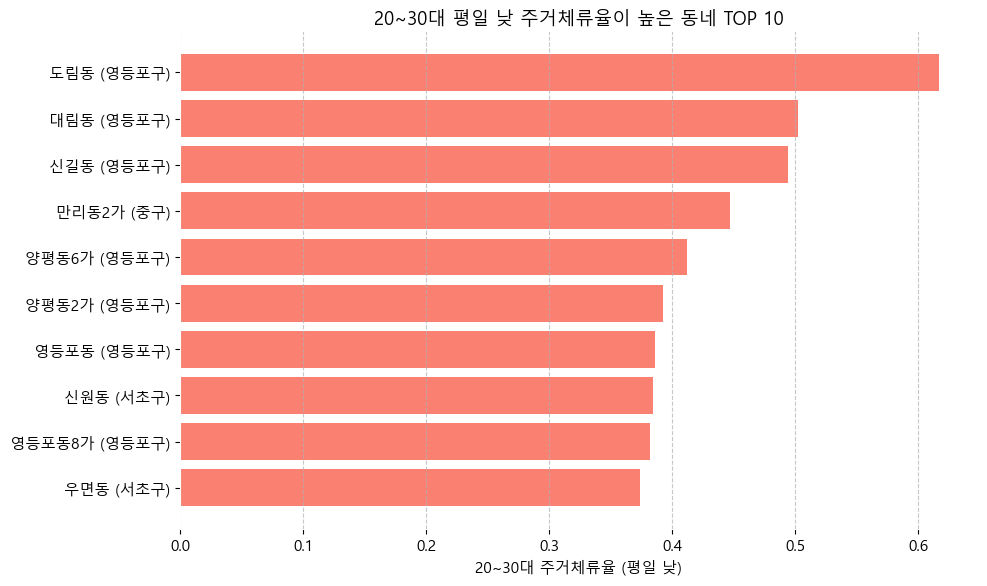

In [326]:
# 20-30대 평일 낮 시간대 주거체류율 높은 동네 
import pandas as pd
import matplotlib.pyplot as plt

# 1. 20~30대, 평일, 낮 시간대 필터링
target_age = ['20', '25', '30', '35']  # 연령대는 필요에 따라 조정
daytime_slots = ['점심', '오후']

filtered_df = float_df[
    (float_df['WEEKDAY_WEEKEND'] == 'W') &
    (float_df['TIME_SLOT'].isin(daytime_slots)) &
    (float_df['AGE_GROUP'].isin(target_age))
].copy()

# 2. 총 유동인구 및 주거체류율 계산
filtered_df['TOTAL_POPULATION'] = (
    filtered_df['RESIDENTIAL_POPULATION'] +
    filtered_df['WORKING_POPULATION'] +
    filtered_df['VISITING_POPULATION']
)

filtered_df = filtered_df[filtered_df['TOTAL_POPULATION'] > 0]  # 0 나눗셈 방지
filtered_df['RESIDENTIAL_RATIO'] = filtered_df['RESIDENTIAL_POPULATION'] / filtered_df['TOTAL_POPULATION']

# 3. 행정동 단위로 평균 주거체류율 계산
grouped = filtered_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['RESIDENTIAL_RATIO'].mean().reset_index()

# 4. 주거체류율 높은 TOP 10 동네
top10 = grouped.sort_values(by='RESIDENTIAL_RATIO', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.barh(top10['DISTRICT_NAME'] + ' (' + top10['CITY_NAME'] + ')', top10['RESIDENTIAL_RATIO'], color='salmon')
plt.xlabel('20~30대 주거체류율 (평일 낮)')
plt.title('20~30대 평일 낮 주거체류율이 높은 동네 TOP 10')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [328]:
# 유동인구에서 20~30대 평일 낮 주거체류율 데이터 추출
target_age = ['20', '25', '30', '35']
daytime_slots = ['점심', '오후']

filtered_df = float_df[
    (float_df['WEEKDAY_WEEKEND'] == 'W') &
    (float_df['TIME_SLOT'].isin(daytime_slots)) &
    (float_df['AGE_GROUP'].isin(target_age))
].copy()

filtered_df['TOTAL_POPULATION'] = (
    filtered_df['RESIDENTIAL_POPULATION'] +
    filtered_df['WORKING_POPULATION'] +
    filtered_df['VISITING_POPULATION']
)

filtered_df = filtered_df[filtered_df['TOTAL_POPULATION'] > 0]
filtered_df['RESIDENTIAL_RATIO'] = filtered_df['RESIDENTIAL_POPULATION'] / filtered_df['TOTAL_POPULATION']

# 동별 평균 주거체류율
resident_ratio_df = filtered_df.groupby(['CITY_NAME', 'DISTRICT_NAME'])['RESIDENTIAL_RATIO'].mean().reset_index()


# 커피 데이터 
merged = pd.merge(resident_ratio_df, card_selected_df, on = ['CITY_NAME', 'DISTRICT_NAME'])

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.regplot(data=merged, x='RESIDENTIAL_RATIO', y='COFFEE_SALES', scatter_kws={'s': 60, 'alpha': 0.7})
plt.xlabel('20~30대 주거체류율 (평일 낮)')
plt.ylabel('커피 소비액 또는 소비량')
plt.title('청년 주거체류율과 커피 소비의 관계')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 